# TASK 1

This is the first file of the analysis of Group J for Luiss X Free To X, in which are performed:
* Explanatory Data Analysis (EDA), in which the datasets provided CDR, Hypercharge locations, Hypercharge Sessions, and PDR Locations are cleaned and their missing values represented; then are removed the columns that are not useful to be analyzed (are removed the ones with all missing values), depending also on their size.
* Are merged Hypercharge Session and Hypercharge Location datasets

In [84]:
#!pip install geopandas
#!pip install folium
#!pip install plotly-express

### Libraries to import before running:

In [175]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import folium
from folium.plugins import MarkerCluster
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import plotly_express as px
import missingno as msno
from geopy.geocoders import Nominatim
from datetime import datetime
import time

## Explanatory Data Analysis

In [197]:
directory ="./dataset/full"

filename_cdr="cdr.csv"                         # Charging Data Records
filename_hloc="hypercarge_locations.csv"       # Hypercarge Locations
filename_hses="hypercarge_sessions.parquet"    # Hypercarge Sessions
filename_pdr_loc="pdr_locations.csv"           # Point of Charge Locations

In [198]:
def read_file(file):
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(directory, file))
    elif file.endswith(".parquet"):
        df = pd.read_parquet(os.path.join(directory, file))
    else:
        print("Invalid file type")
        return None
    return df

In [199]:
cdr=read_file(filename_cdr)
hloc=read_file(filename_hloc)
hses=read_file(filename_hses)
pdr_loc=read_file(filename_pdr_loc)

## Data Cleaning and Missing Values Representation

In [200]:
for df in [cdr, hloc, hses, pdr_loc]:
    df[:]=df.map(lambda cell: np.nan if isinstance(cell, str) and cell in ['-', ''] else cell)

In [201]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [202]:
def create_summary(file):
    dataframe = pd.DataFrame({'Variable Name': file.columns,
        'Number of Missing Values': [file[col].isna().sum() for col in file.columns],
        'Number of Unique Values':  [file[col].nunique() if not (file[col].apply(lambda x: isinstance(x, np.ndarray)).any()) else None for col in file.columns],
        'Data type': [file[col].dtype for col in file.columns]})
    return dataframe

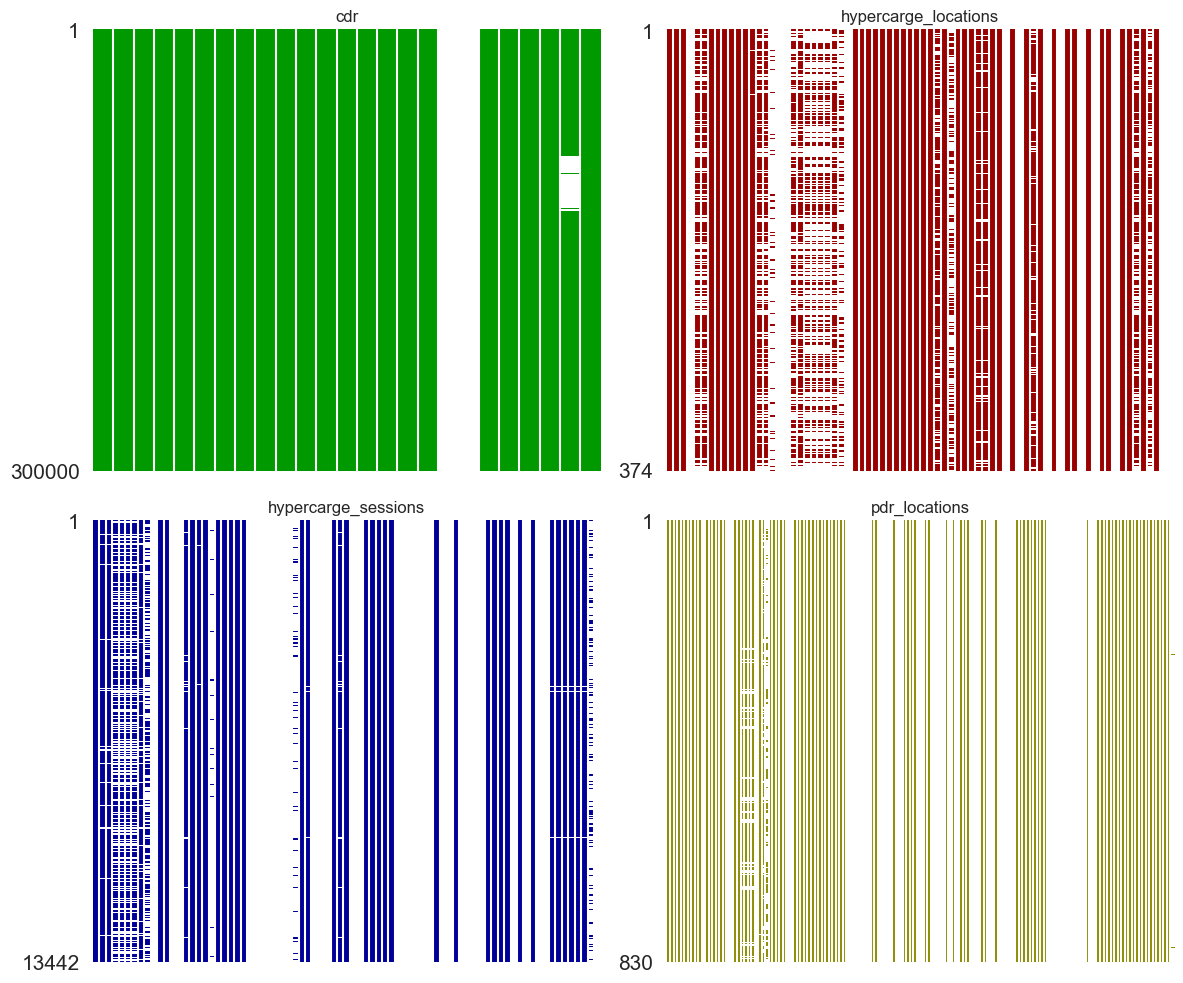

In [203]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

msno.matrix(cdr, ax=axes[0, 0], fontsize=12, labels=False, sparkline=False, color=(0, 0.6, 0))
axes[0, 0].set_title('cdr')
msno.matrix(hloc, ax=axes[0, 1], fontsize=12, labels=False, sparkline=False, color=(0.6, 0, 0))
axes[0, 1].set_title('hypercarge_locations')
msno.matrix(hses, ax=axes[1, 0], fontsize=12, labels=False, sparkline=False, color=(0, 0, 0.6))
axes[1, 0].set_title('hypercarge_sessions')
msno.matrix(pdr_loc, ax=axes[1, 1], fontsize=12, labels=False, sparkline=False, color=(0.55, 0.55, 0))
axes[1, 1].set_title('pdr_locations')

plt.tight_layout()

Through the **missingno** library it's possible to visualize missing data from the datasets (cdr, hloc, hses, and pdr_loc) as matrix plots, where each subplot shows the completeness of data in each column (color blocks indicate non-missing data). In particular, across the datasets cdr is the once that presents less missing values and a more compact representation, also due to it's reduced size.

In [204]:
dfs=[]
for file, name in zip([cdr, hloc, hses, pdr_loc], ['Charging Data Records', 'Hypercarge Locations', 'Hypercarge Sessions', 'Point of Charge Locations']):
    miss_val= [file[col].isna().sum() for col in file.columns]
    var_name = file.columns
    filename=name
    total_r=file.shape[0]

    dfs.append(pd.DataFrame({"File name": filename, "Variable":var_name, "Missing Values":miss_val, "Total Rows":total_r}))
df=pd.concat(dfs)
df=df[df["Missing Values"]!=0]
df["N/A Percentage"]=df["Missing Values"]/df["Total Rows"]*100
df.sort_values(by="N/A Percentage", ascending=False, inplace=True)

fig = px.bar(df,
             orientation="h", 
             y='Variable', 
             x='N/A Percentage', 
             color="File name", 
             color_discrete_map={'Charging Data Records': 'green', 
                                 'Hypercarge Locations': 'red', 
                                 'Hypercarge Sessions': 'blue',
                                 'Point of Charge Locations': 'yellow'}, 
            title='Percentage of missing values per variable')
fig.show()

The **bar chart** shows the percentage of missing values per variable across the datasets, a higher bar is correlated to a higher percentage of missing values in that column.

In [205]:
def display_missing_values(df, dataset_name):
    missing_values = df.isna().sum()
    missing_percentage = (missing_values / len(df)) * 100
    
    missing_summary = pd.DataFrame({
        'Number of Missing Values': missing_values,
        'Percentage of Missing Values (%)': missing_percentage
    })
    
    print(f"Missing Values in '{dataset_name}':\n")
    display(missing_summary.sort_values(by='Number of Missing Values', ascending=False))
    print("\n" + "-"*50 + "\n")

display_missing_values(cdr, 'Charging Data Records')
display_missing_values(hloc, 'Hypercarge Locations')
display_missing_values(hses, 'Hypercarge Sessions')
display_missing_values(pdr_loc, 'Point of Charge Locations')

Missing Values in 'Charging Data Records':



,Number of Missing Values,Percentage of Missing Values (%)
Auth ID,299998,99.9993333333
Contachilometri (Km),299980,99.9933333333
EMI3 ID,37040,12.3466666667
Type Status,79,0.0263333333
Energia (kWh),0,0.0000000000
Tipo di presa,0,0.0000000000
Auth method,0,0.0000000000
Partner session ID,0,0.0000000000
Auth ID.1,0,0.0000000000
Inizio penalty time,0,0.0000000000



--------------------------------------------------

Missing Values in 'Hypercarge Locations':



,Number of Missing Values,Percentage of Missing Values (%)
lendeeName,374,100.0000000000
serviceExpirationDate,374,100.0000000000
defaultSoftwareVersion,374,100.0000000000
officialEichrechtCompletion,374,100.0000000000
endClientId,374,100.0000000000
operatorId,374,100.0000000000
endClientName,374,100.0000000000
operatorName,374,100.0000000000
calibrationLawOrdered,374,100.0000000000
softwareExpirationDate,374,100.0000000000



--------------------------------------------------

Missing Values in 'Hypercarge Sessions':



,Number of Missing Values,Percentage of Missing Values (%)
carChargeParameter,13442,100.0000000000
session.averageAmp,13442,100.0000000000
session.producer,13442,100.0000000000
session.averagePower,13442,100.0000000000
session.analysisComment,13442,100.0000000000
session.analysisTimestamp,13442,100.0000000000
session.analyzedBy,13442,100.0000000000
session.stopU,13442,100.0000000000
session.car,13442,100.0000000000
session.distributorName,13442,100.0000000000



--------------------------------------------------

Missing Values in 'Point of Charge Locations':



,Number of Missing Values,Percentage of Missing Values (%)
station_owner_company_parent_company_id,830,100.0000000000
station_owner_company_user_id,830,100.0000000000
station_owner_company_deadline,830,100.0000000000
station_owner_company_id_offer,830,100.0000000000
station_owner_company_pin_color,830,100.0000000000
station_owner_company_endpoint,830,100.0000000000
station_owner_company_created_at,830,100.0000000000
station_owner_company_heycharge_email,830,100.0000000000
station_owner_company_heycharge_api_key,830,100.0000000000
station_payment_terminal_sn,830,100.0000000000



--------------------------------------------------



For missing values handling strategy, columns are removed if they have **all missing values**.

In [206]:
columns_removed_cdr = cdr.columns[cdr.isna().all()].tolist()
if columns_removed_cdr:
    print(f"Columns removed from 'Charging Data Records' (all missing values): {columns_removed_cdr}")
    cdr.drop(columns=columns_removed_cdr, inplace=True)
else:
    print("No columns removed from 'Charging Data Records' (all missing values).")
print(f"New shape of 'Charging Data Records': {cdr.shape}\n")

columns_removed_hloc = hloc.columns[hloc.isna().all()].tolist()
if columns_removed_hloc:
    print(f"Columns removed from 'Hypercarge Locations' (all missing values): {columns_removed_hloc}")
    hloc.drop(columns=columns_removed_hloc, inplace=True)
else:
    print("No columns removed from 'Hypercarge Locations' (all missing values).")
print(f"New shape of 'Hypercarge Locations': {hloc.shape}\n")

columns_removed_hses = hses.columns[hses.isna().all()].tolist()
if columns_removed_hses:
    print(f"Columns removed from 'Hypercarge Sessions' (all missing values): {columns_removed_hses}")
    hses.drop(columns=columns_removed_hses, inplace=True)
else:
    print("No columns removed from 'Hypercarge Sessions' (all missing values).")
print(f"New shape of 'Hypercarge Sessions': {hses.shape}\n")

columns_removed_pdr_loc = pdr_loc.columns[pdr_loc.isna().all()].tolist()
if columns_removed_pdr_loc:
    print(f"Columns removed from 'Point of Charge Locations' (all missing values): {columns_removed_pdr_loc}")
    pdr_loc.drop(columns=columns_removed_pdr_loc, inplace=True)
else:
    print("No columns removed from 'Point of Charge Locations' (all missing values).")
print(f"New shape of 'Point of Charge Locations': {pdr_loc.shape}\n")



No columns removed from 'Charging Data Records' (all missing values).
New shape of 'Charging Data Records': (300000, 25)

Columns removed from 'Hypercarge Locations' (all missing values): ['sshPort', 'serviceExpirationDate', 'softwareExpirationDate', 'calibrationLawOrdered', 'lastMaintenance', 'defaultSoftwareVersion', 'officialEichrechtCompletion', 'endClientId', 'operatorId', 'endClientName', 'operatorName', 'lendeeId', 'lendeeName']
New shape of 'Hypercarge Locations': (374, 61)

Columns removed from 'Hypercarge Sessions' (all missing values): ['endClientName', 'operatorName', 'lendeeName', 'session.averageAmp', 'session.averagePinTempMinus', 'session.averagePinTempPlus', 'session.averagePower', 'session.analysisComment', 'session.analysisTimestamp', 'session.analyzedBy', 'session.car', 'session.distributorName', 'session.distributorId', 'session.hasOcmfData', 'session.hycErrorcode', 'session.physicalPosition', 'session.peakAmp', 'session.peakPinTempMinus', 'session.peakPinTempPlus'

In [207]:
cdr_cleaned = cdr.copy()
hloc_cleaned = hloc.copy()
hses_cleaned = hses.copy()
pdr_loc_cleaned = pdr_loc.copy()

The **cleaned datasets** are now saved in new variables for being successively handled.

In [208]:
cdr_cleaned.sample(5)

,CDR ID,EVSE ID,Operatore,Potenza (kW),Station Nome,Station Città,Station Indirizzo,Data inizio,Ora inizio,Data fine,Ora fine,Ricavi totali (€) (IVA esclusa),Ricavi Energia (€) (IVA esclusa),Energia (kWh),Ricavi Penalty Time (€) (IVA esclusa),Tempo Totale (min),Inizio penalty time,Contachilometri (Km),Auth ID,Auth ID.1,Partner session ID,Auth method,Tipo di presa,EMI3 ID,Type Status
247651,1633845,IT*F2X*EF2XITLINC05*1,IT*AES,300.0000000000,Aeroporto - Linate Commerciale,Milano,Aeroporto Linate Commerciale,2024-02-18,12:04:05,2024-02-18,12:42:58,23.7500000000,23.7500000000,34.9200000000,0.0000000000,38,0,NaN,NaN,95802,4cdb89db-7b07-430f-9f75-9e1e048a9a83,AUTH_REQUEST,COMBO,IT*ASP,public
136081,1250047,IT*F2X*EF2XITM3101*1,IT*BEC,300.0000000000,Area di Servizio - Adige Ovest,Costa di Rovigo,"A13, Bologna - Padova",2023-10-11,14:04:28,2023-10-11,14:41:24,17.0500000000,17.0500000000,25.0800000000,0.0000000000,36,0,NaN,NaN,IT-BEC-CUFMFTH9H-A,cb4a2e0f-0e83-4668-873b-8f5938a86e3d,AUTH_REQUEST,COMBO,IT*ASP,public
118442,1206164,IT*F2X*EF2XITB4002*2,IT*EVY,300.0000000000,Area di Servizio - La Macchia Est,Anagni,Autostrada del Sole,2023-09-26,16:27:38,2023-09-26,17:14:44,22.3000000000,22.3000000000,32.7980000000,0.0000000000,47,0,NaN,NaN,ITEVYCZE92553JF,3a1735d8-ce04-4f6c-adcc-12a3ec0281da,AUTH_REQUEST,COMBO,NaN,public
188497,1381439,IT*F2X*EF2XITN5002*1,IT*BEC,300.0000000000,Area di Servizio - Esino Est,Chiaravalle,Autostrada Adriatica,2023-11-26,17:54:37,2023-11-26,18:10:30,12.2900000000,12.2900000000,18.0800000000,0.0000000000,15,0,NaN,NaN,IT-BEC-CC7OU6ZZI-6,4a946f2d-5037-4d5b-ad98-57d0088255a6,AUTH_REQUEST,COMBO,IT*ASP,public
102763,1166978,IT*F2X*EF2XITD5102*2,IT*ENE,300.0000000000,Area di Servizio - Valtrompia Sud,Roncadelle,A4 Torino - Trieste,2023-09-14,00:36:40,2023-09-14,00:42:42,7.2900000000,7.2900000000,10.7160000000,0.0000000000,6,0,NaN,NaN,04881802566780,76c1a3c6-0df2-4f2e-a518-a198e4d0cfb7,AUTH_REQUEST,COMBO,NaN,public


In [209]:
def display_missing_values(df, dataset_name):
    missing_values = df.isna().sum()
    missing_percentage = (missing_values / len(df)) * 100
    
    missing_summary = pd.DataFrame({
        'Number of Missing Values': missing_values,
        'Percentage of Missing Values (%)': missing_percentage
    })
    
    
    print(f"Missing Values in '{dataset_name}':\n")
    display(missing_summary.sort_values(by='Number of Missing Values', ascending=False))
    print("\n" + "-"*50 + "\n")

display_missing_values(cdr_cleaned, 'Charging Data Records')
display_missing_values(hloc_cleaned, 'Hypercarge Locations')
display_missing_values(hses_cleaned, 'Hypercarge Sessions')
display_missing_values(pdr_loc_cleaned, 'Point of Charge Locations')


Missing Values in 'Charging Data Records':



,Number of Missing Values,Percentage of Missing Values (%)
Auth ID,299998,99.9993333333
Contachilometri (Km),299980,99.9933333333
EMI3 ID,37040,12.3466666667
Type Status,79,0.0263333333
Energia (kWh),0,0.0000000000
Tipo di presa,0,0.0000000000
Auth method,0,0.0000000000
Partner session ID,0,0.0000000000
Auth ID.1,0,0.0000000000
Inizio penalty time,0,0.0000000000



--------------------------------------------------

Missing Values in 'Hypercarge Locations':



,Number of Missing Values,Percentage of Missing Values (%)
customerIccid,336,89.8395721925
locationUpdateNote,252,67.3796791444
locationZipCode,221,59.0909090909
locationProvince,221,59.0909090909
locationTown,221,59.0909090909
locationStreet,221,59.0909090909
status_text,213,56.9518716578
sessionLiveViewEnabled,160,42.7807486631
warrantyExpiration,160,42.7807486631
locationCountry,147,39.3048128342



--------------------------------------------------

Missing Values in 'Hypercarge Sessions':



,Number of Missing Values,Percentage of Missing Values (%)
producer,13013,96.8085106383
session.errorCode,11911,88.6103258444
carChargeParameter.batteryCapacity,9736,72.4296979616
locationUpdateNote,7294,54.2627585181
locationStreet,4511,33.5589941973
locationZipCode,4511,33.5589941973
locationTown,4511,33.5589941973
locationProvince,4511,33.5589941973
locationCountry,1207,8.9793185538
gpsLat,464,3.4518672817



--------------------------------------------------

Missing Values in 'Point of Charge Locations':



,Number of Missing Values,Percentage of Missing Values (%)
connector_isSuspended,819,98.6746987952
station_commissioning_date,545,65.6626506024
station_installation_date,122,14.6987951807
station_serial_number,79,9.5180722892
station_firmware,79,9.5180722892
station_model,79,9.5180722892
station_brand,79,9.5180722892
station_type_status,2,0.2409638554
station_owner_company_owner_cost_per_kwh,0,0.0000000000
station_owner_company_brand_color,0,0.0000000000



--------------------------------------------------



Now, after the cleaning step, it's possible to see that the rate of missing values across the datasets has reduced.

In [210]:
print(f"New shape of 'Charging Data Records': {cdr_cleaned.shape}")
print(f"New shape of 'Hypercarge Locations': {hloc_cleaned.shape}")
print(f"New shape of 'Hypercarge Sessions': {hses_cleaned.shape}")
print(f"New shape of 'Point of Charge Locations': {pdr_loc_cleaned.shape}")

New shape of 'Charging Data Records': (300000, 25)
New shape of 'Hypercarge Locations': (374, 61)
New shape of 'Hypercarge Sessions': (13442, 47)
New shape of 'Point of Charge Locations': (830, 94)


Are displayed the new shapes of the datasets.

In [211]:
summary_cdr = create_summary(cdr)
columns_to_investigate = summary_cdr[(summary_cdr['Number of Unique Values'] == 1)]['Variable Name'].tolist()

for col in columns_to_investigate:
    print(f"Unique value in '{col}': {cdr[col].unique()}       {cdr[col].isna().sum()}")

Unique value in 'Ricavi Penalty Time (€) (IVA esclusa) ': [0.]       0
Unique value in 'Inizio penalty time': [0]       0
Unique value in 'Auth ID': [nan 'LOCAL']       299998
Unique value in 'Auth method': ['AUTH_REQUEST']       0
Unique value in 'Type Status': ['public' nan]       79


In [212]:
summary_hloc = create_summary(hloc)
columns_to_investigate = summary_hloc[(summary_hloc['Number of Unique Values'] == 1)]['Variable Name'].tolist()

for col in columns_to_investigate:
    print(f"Unique value in '{col}': {hloc[col].unique()}       {hloc[col].isna().sum()}")

Unique value in 'emergencyStop': [False]       0
Unique value in 'standAloneOrBackend': ['Backend']       0
Unique value in 'isPublic': [False]       0
Unique value in 'websocketUrl': ['ws://in-cpo.evway.net/ocpp/cpo' nan]       114
Unique value in 'locationCountry': ['Italy' nan]       147
Unique value in 'prohibitSoftwareupdates': [False]       0
Unique value in 'needsSpecialAccess': [False]       0
Unique value in 'notServiceable': [False]       0
Unique value in 'hwVersion': [4]       0
Unique value in 'isRemoteLocation': [False]       0
Unique value in 'status_position': [0]       0
Unique value in 'status_isPrivate': [False]       0
Unique value in 'excludeFromStatistics': [False]       0
Unique value in 'isUtilityExecutionBlocked': [False]       0
Unique value in 'creditCardTerminalActive': [False]       0
Unique value in 'enableClientWebinterface': [False]       0
Unique value in 'hasVollmacht': [False]       0
Unique value in 'hasCommissioningProtocol': [False]       0
Unique 

In [213]:
summary_hses = create_summary(hses)
columns_to_investigate = summary_hses[(summary_hses['Number of Unique Values'] == 1)]['Variable Name'].tolist()

for col in columns_to_investigate:
    print(f"Unique value in '{col}': {hses[col].unique()}       {hses[col].isna().sum()}")

Unique value in 'locationCountry': ['Italy' None]       1207
Unique value in 'producer': [None 'Amphenol']       13013
Unique value in 'hasOcmfData': [False]       0
Unique value in 'session.isNoStopTracked': [False]       0
Unique value in 'session.timestampUncertain': [False]       0


In [214]:
summary_pdr_loc = create_summary(pdr_loc)
columns_to_investigate = summary_pdr_loc[(summary_pdr_loc['Number of Unique Values'] == 1)]['Variable Name'].tolist()

for col in columns_to_investigate:
    print(f"Unique value in '{col}': {pdr_loc[col].unique()}       {pdr_loc[col].isna().sum()}")

Unique value in 'station_country_id': ['IT']       0
Unique value in 'station_country': ['Italy']       0
Unique value in 'station_type_name': ['PARKING_LOT']       0
Unique value in 'station_station_type_id': [4]       0
Unique value in 'station_is_offline': [False]       0
Unique value in 'station_is_at_home': [False]       0
Unique value in 'station_is_qr_private_enable': [False]       0
Unique value in 'station_owner_company_id': [31370]       0
Unique value in 'station_owner_company_uid': ['27598fda-fcc1-4f20-9a24-c1af964d57ee']       0
Unique value in 'station_owner_company_name': ['Free to X']       0
Unique value in 'station_owner_company_eMI3_id': ['IT*ASP']       0
Unique value in 'station_owner_company_imported': [0]       0
Unique value in 'station_owner_company_description_en': ['Revolutionize your travel experience. Free to X is committed to building the largest high-speed charging network for electric vehicles in the motorway sector in Italy. The goal is to accompany you

Another step of the EDA has been to check the number of **unique and multiple values** within each column, to understand whether there were other not useful columns.

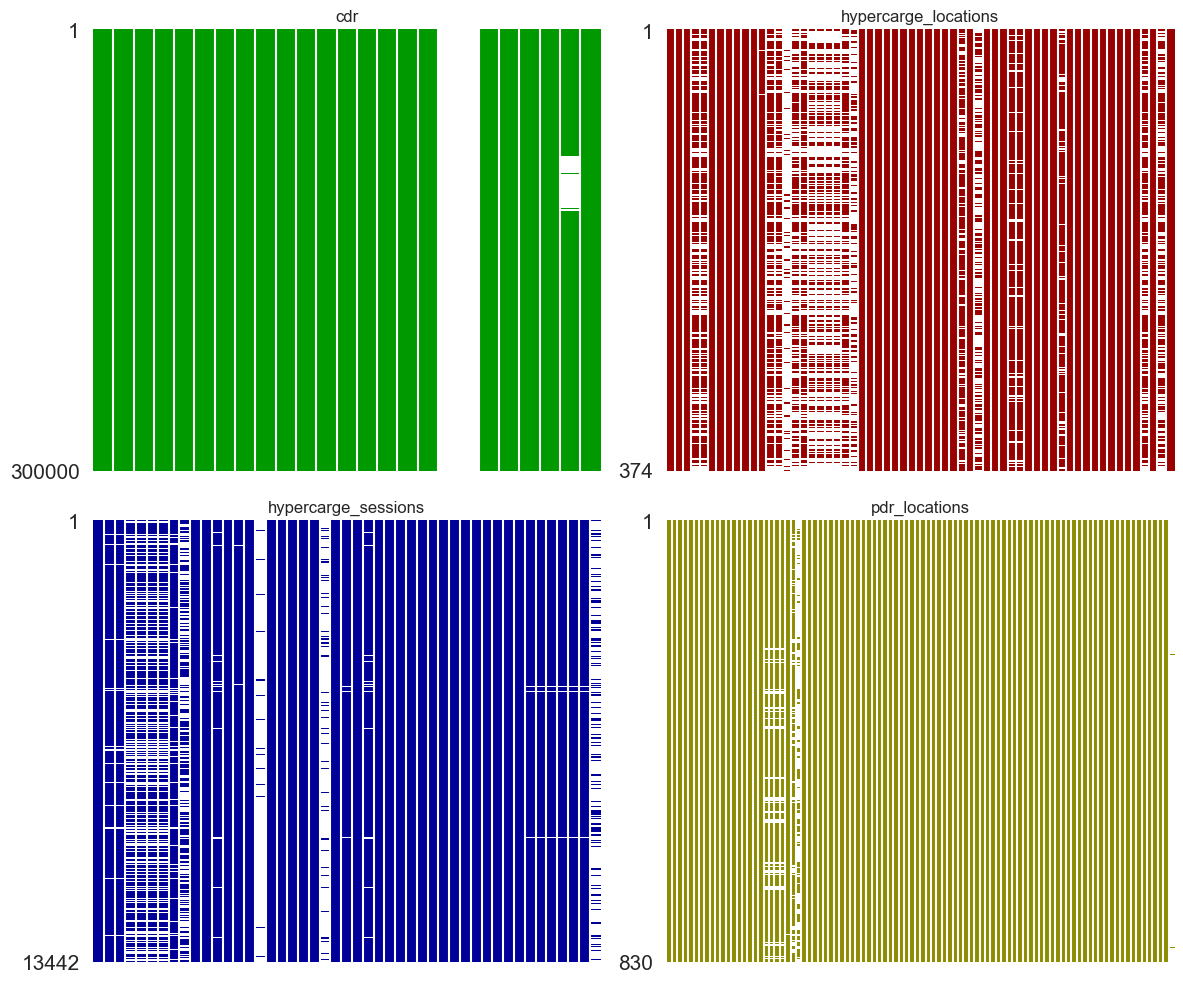

In [215]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

msno.matrix(cdr, ax=axes[0, 0], fontsize=12, labels=False, sparkline=False, color=(0, 0.6, 0))
axes[0, 0].set_title('cdr')
msno.matrix(hloc, ax=axes[0, 1], fontsize=12, labels=False, sparkline=False, color=(0.6, 0, 0))
axes[0, 1].set_title('hypercarge_locations')
msno.matrix(hses, ax=axes[1, 0], fontsize=12, labels=False, sparkline=False, color=(0, 0, 0.6))
axes[1, 0].set_title('hypercarge_sessions')
msno.matrix(pdr_loc, ax=axes[1, 1], fontsize=12, labels=False, sparkline=False, color=(0.55, 0.55, 0))
axes[1, 1].set_title('pdr_locations')

plt.tight_layout()

Also from the plots created through the Missingno library, it's possible to see that after the cleaning process the distribution of the datasets is much better than before.
Particularly in the cdr dataset there are columns that seems not to be useful having all missing values, but as seen from the missing values rate representation, there are very few values that, however, are important in the following of the analysis.
Therefore, the decision was not to drop those columns.

In [216]:
dfs=[]
for file, name in zip([cdr_cleaned, hloc_cleaned, hses_cleaned, pdr_loc_cleaned], ['Charging Data Records', 'Hypercarge Locations', 'Hypercarge Sessions', 'Point of Charge Locations']):
    miss_val= [file[col].isna().sum() for col in file.columns]
    var_name = file.columns
    filename=name
    total_r=file.shape[0]

    dfs.append(pd.DataFrame({"File name": filename, "Variable":var_name, "Missing Values":miss_val, "Total Rows":total_r}))
df=pd.concat(dfs)
df=df[df["Missing Values"]!=0]
df["N/A Percentage"]=df["Missing Values"]/df["Total Rows"]*100
df.sort_values(by="N/A Percentage", ascending=False, inplace=True)

fig = px.bar(df,
             orientation="h", 
             y='Variable', 
             x='N/A Percentage', 
             color="File name", 
             color_discrete_map={'Charging Data Records': 'green', 
                                 'Hypercarge Locations': 'red', 
                                 'Hypercarge Sessions': 'blue',
                                 'Point of Charge Locations': 'yellow'}, 
            title='Percentage of missing values per variable')
fig.show()

# 

As could be seen, after the Data Cleaning process the number of **missing values for each dataset decreased exponentially**.

## Merge Hypercharge Session and Hypercharge Location

In [195]:
valori_comuni = hses['serialNumber'][hses['serialNumber'].isin(hloc['serialNumber'])]
valori_non_comuni = hses['serialNumber'][~hses['serialNumber'].isin(hloc['serialNumber'])]
print(f"Values in common: {valori_comuni.nunique()}, valori non in comune: {valori_non_comuni.nunique()}")

Values in common: 259, valori non in comune: 0


In [217]:
hych=pd.merge(hses, hloc_cleaned, on=['serialNumber', 'gpsLat', 'gpsLong','locationStreet', 'locationTown', 
                              'locationProvince','locationCountry', 'locationUpdateNote', 
                              'distributorName', 'corporationName'], how="left")

hych['locationZipCode_x'].fillna(hych['locationZipCode_y'], inplace=True)
hych.drop(columns=['locationZipCode_y'], inplace=True)

pdr_loc['connector_evse_id'] = pdr_loc['connector_evse_id'].str.replace(r'\*\d$', '', regex=True)
lat_mapping = pdr_loc.set_index('connector_evse_id')['station_coordinates_lat'].to_dict()
lon_mapping = pdr_loc.set_index('connector_evse_id')['station_coordinates_lon'].to_dict()

hych['gpsLat'] = hych['chargePointIdentity'].map(lat_mapping).combine_first(hych['gpsLat'])
hych['gpsLong'] = hych['chargePointIdentity'].map(lon_mapping).combine_first(hych['gpsLong'])

display(hych.sample(5))

/var/folders/n5/yvhs1y856g10wj7dfwsql5h40000gn/T/ipykernel_85151/3028105676.py:5: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





,serialNumber,gpsLat,gpsLong,locationStreet,locationZipCode_x,locationTown,locationProvince,locationCountry,locationUpdateNote,distributorName,corporationName,evId,type,physicalPosition,cableLength,producer,chargingSessionGraphData,stackErrors,chargingSessionErrors,stackOszis,hasOcmfData,session.errorCode,session.creationTime,session.carChargeParameterId,session.end,session.evId,session.falsePositive,session.isNoStopTracked,session.logRequestExecuted,session.logRequestResult,session.meterStart,session.meterStop,session.reason,session.start,session.socStart,session.socStop,session.softwareVersion,session.chargingSessionId,session.timestampUncertain,session.position,carChargeParameter.carChargeParameterId,carChargeParameter.voltage,carChargeParameter.maxPower,carChargeParameter.current,carChargeParameter.car,carChargeParameter.excludeFromStatistics,carChargeParameter.batteryCapacity,chargerId,sshurl,numberStacks,chassis,emergencyStop,doorContactSwitch,standAloneOrBackend,isPublic,simIccid,commissioningDate,chargePointIdentity,customerIccid,warrantyExpiration,websocketUrl,prohibitSoftwareupdates,needsSpecialAccess,notServiceable,deadManSwitch,hwVersion,telemetrySave,hymaintInstalled,isRemoteLocation,lastSignOfLife,outletList,status_position,status_errorcode,status_hycErrorCode,status_status,status_text,status_updatetime,status_isPrivate,simActivated,simActivationDate,simLastRequest,excludeFromStatistics,isActive,softwareVersion,isUtilityExecutionBlocked,hymaintVersion,allNotes,creditCardTerminalActive,distributorId,corporationId,enableClientWebinterface,hasVollmacht,hasCommissioningProtocol,surroundingChargers,isFavourite,sessionLiveViewEnabled,finishedEol
4747,22BZ6980B,41.0958030000,16.7697340000,None,NaN,None,None,Italy,CellTower localization!,Free To X S.p.A.,Free To X S.p.A.,93428156517702,CCS2_400,4.0000000000,500,None,"[{'currentEv': 0.0, 'currentEvse': 0.1, 'curre...",[],"[{'cause': 'loganalyze', 'chargingSessionError...",[],False,None,2024-07-28T15:46:45.777472+00:00,9719.0000000000,2024-07-28T16:14:35+00:00,93428156517702,False,False,True,Success,20855076,20900144,Local,2024-07-28T15:46:44+00:00,26,79,hyc_v1.8.3,71582166,False,2,9719.0000000000,423.0000000000,326000.0000000000,799.0000000000,Tesla Model Y / 3 LR,False,NaN,16945.0000000000,10.245.21.66,4.0000000000,HYC_300,False,True,Backend,False,8945020282314315776.0000000000,2023-04-12T00:00:00,IT*F2X*EF2XITO4502,NaN,2024-12-22T00:00:00,ws://in-cpo.evway.net/ocpp/cpo,False,False,False,False,4.0000000000,0.0000000000,True,False,2024-09-03T20:37:31.129917+00:00,"[{'outletId': 114524, 'chargerId': 16945, 'pos...",0.0000000000,NoError,NoError,Available,NaN,2024-09-03T14:25:17+00:00,False,True,2022-11-18T00:00:00+00:00,2022-12-06T05:50:02.023597+00:00,False,True,hyc_v1.8.3,False,2.4.2,"[{'chargerNoteId': 1100830, 'chargerId': 16945...",False,180.0000000000,180.0000000000,False,False,False,"[{'chargerId': 10538, 'gpsLat': 41.25078, 'gps...",False,False,True
2656,22BZ6969B,44.1169300000,12.4089550000,Autostrada Adriatica km 632,47039,Savignano sul Rubicone,Emilia-Romagna,Italy,NaN,Free To X S.p.A.,Free To X S.p.A.,264428453505242,CCS2_400,1.0000000000,500,None,"[{'currentEv': 0.7, 'currentEvse': 0.0, 'curre...",[],"[{'cause': 'loganalyze', 'chargingSessionError...",[],False,None,2024-07-22T10:45:49.0178+00:00,671.0000000000,2024-07-22T11:02:48+00:00,264428453505242,False,False,True,Success,57480788,57517692,Local,2024-07-22T10:45:48+00:00,38,83,hyc_v1.8.3,70538128,False,1,671.0000000000,464.0000000000,0.0000000000,350.0000000000,Audi E-tron Coupe?,False,0.0000000000,16934.0000000000,10.244.159.103,4.0000000000,HYC_300,False,True,Backend,False,8945020282301440000.0000000000,2023-03-30T00:00:00,IT*F2X*EF2XITN3002,NaN,2024-12-14T00:00:00,ws://in-cpo.evway.net/ocpp/cpo,False,False,False,False,4.0000000000,0.0000000000,True,False,2024-09-03T20:33:37.978534+00:00,"[{'outletId': 114542, 'chargerId': 16934, 'pos...",0.0000000000,NoError,NoError,Available,NaN,2024-09-03T18:56:19+00:0

In [112]:
hych[~hych["chargePointIdentity"].isna()].shape

(11092, 97)

Hypercharge locations and Hypercharge Sessions have the following columns in common: 'serialNumber', 'gpsLat', 'gpsLong', 'locationStreet', 'locationTown', 'locationZipCode', 'locationProvince', 'locationCountry', 'locationUpdateNote', 'distributorName', 'corporationName'.

This is useful for further analysis using the columns of both datasets.

## FreeToX Network Distribution

Here is represented the distribution of the FreeToX station's network across Italy. As could be seen, the higher concentration of stations is in Lombardia, north-west Italy, with 82 charging stations.
The map is interactive, so by zooming in it's possible to have more details about the exact locations of the charging stations, the number of charging points, and the stations ID.

In [220]:
selected_columns = ['station_coordinates_lat', 'station_coordinates_lon', 'station_name', 'station_address', 'connector_status', 'station_id', 'station_postal_code', 'station_city', 'station_country', 'station_type_name', 'station_brand', 'station_type_status']

filtered_df = pdr_loc_cleaned[selected_columns]

filtered_df = filtered_df.drop_duplicates(subset='station_id')

italy_map = folium.Map(location=[41.8719, 12.5674], zoom_start=6, tiles='CartoDB positron')

marker_cluster = MarkerCluster().add_to(italy_map)

for _, row in filtered_df.iterrows():
    latitude = row['station_coordinates_lat']
    longitude = row['station_coordinates_lon']
    station_name = row['station_name']
    station_address = row['station_address']
    station_city = row['station_city']
    station_id = row['station_id']

    folium.Marker(
        location=[latitude, longitude],
        popup=f"""
        <strong>Station id:</strong> {station_id}<br>
        <strong>Station Name:</strong> {station_name}<br>
        <strong>Address:</strong> {station_address}<br>
        <strong>Station city:</strong> {station_city}
         """
    ).add_to(marker_cluster)

italy_map



## Stations Over Time

By looking at the number of installed stations over time, it's possible to see that the trend was not always growing up, as could be drawn by the fact that the market of electric chargers is yet competitive.
However, during the 3 years of activity of FreeToX, it's possible to see 3 major trends:
* In **2022**, first year of activity, the recorded value per month never exceded 20 installations.
* In **2023**, despite the previous year, the value increased exponentially, touching peaks of more than 25 installations per month between February and April.
* In **2024**, until now it's possible to see a overall improvement in values, characterized by great fluctuations.

/var/folders/n5/yvhs1y856g10wj7dfwsql5h40000gn/T/ipykernel_85151/108372659.py:3: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



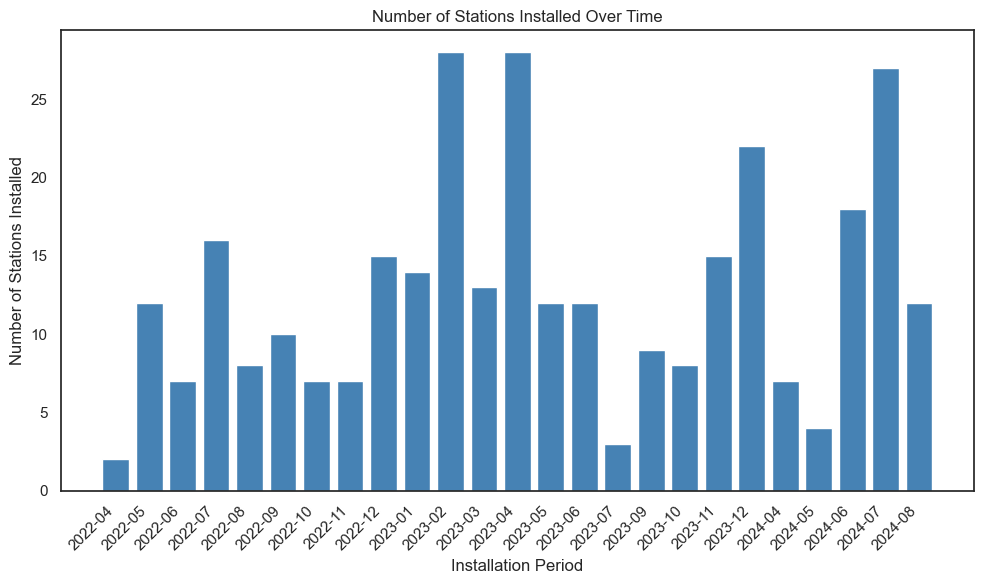

In [221]:
pdr_loc_cleaned['station_installation_date'] = pd.to_datetime(pdr_loc_cleaned['station_installation_date'], errors='coerce')

pdr_loc_cleaned['installation_period'] = pdr_loc_cleaned['station_installation_date'].dt.to_period('M')

stations_per_period = pdr_loc_cleaned.groupby('installation_period')['station_id'].nunique().reset_index()

dark_blue = '#4682B4'

plt.figure(figsize=(10, 6))
plt.bar(stations_per_period['installation_period'].astype(str), stations_per_period['station_id'], color=dark_blue)
plt.xticks(rotation=45, ha='right')
plt.title('Number of Stations Installed Over Time')
plt.xlabel('Installation Period')
plt.ylabel('Number of Stations Installed')

plt.grid(False)

plt.tight_layout()

plt.show()


In [222]:
unique_stations_df = pdr_loc_cleaned.drop_duplicates(subset='station_id')

In [223]:
def get_region_from_postal(postal_code):
    if not postal_code or pd.isnull(postal_code):
        return None
    
    postal_code = str(postal_code)
    
    try:
        response = requests.get(f"http://api.zippopotam.us/it/{postal_code}")
        if response.status_code == 200:
            data = response.json()
            if 'places' in data and len(data['places']) > 0:
                return data['places'][0]['state']
        return None
    except Exception as e:
        print(f"Error fetching region for postal code {postal_code}: {e}")
        return None

unique_stations_df['region'] = unique_stations_df['station_postal_code'].apply(get_region_from_postal)

manual_updates = {
    '5024': 'Umbria',  
    '44121': 'Emilia-Romagna',
    '60': 'Lazio',
    '5015': 'Umbria',
    '10': 'Lazio',
    '1021': 'Lazio',
    '3012': 'Lazio',
    '3030': 'Lazio',
    '2046': 'Lazio',
    '59': 'Lazio',
    '43122': 'Emilia-Romagna',
    '41123': 'Emilia-Romagna',
    '71121': 'Puglia'
}

unique_stations_df['station_postal_code'] = unique_stations_df['station_postal_code'].astype(str)

for postal_code, region in manual_updates.items():
    unique_stations_df.loc[unique_stations_df['station_postal_code'] == postal_code, 'region'] = region

unique_stations_df.sample(5)

/var/folders/n5/yvhs1y856g10wj7dfwsql5h40000gn/T/ipykernel_85151/2124241923.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/n5/yvhs1y856g10wj7dfwsql5h40000gn/T/ipykernel_85151/2124241923.py:38: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,connector_id,connector_station_id,connector_evse_id,connector_connector_status_id,connector_status,connector_uid,station_id,station_uid,station_name,station_address,station_postal_code,station_city,station_country_id,station_country,station_coordinates_lat,station_coordinates_lon,station_type_name,station_station_type_id,station_brand,station_model,station_firmware,station_serial_number,station_type_status,station_installation_date,station_commissioning_date,station_is_offline,station_is_at_home,station_is_qr_private_enable,station_owner_company_id,station_is_visible,station_owner_company_uid,station_owner_company_name,station_owner_company_eMI3_id,station_owner_company_imported,station_owner_company_description_en,station_owner_company_description_it,station_owner_company_description_de,station_owner_company_description_fr,station_owner_company_street,station_owner_company_street_number,station_owner_company_zip,station_owner_company_city,station_owner_company_district,station_owner_company_state,station_owner_company_country,station_owner_company_company_types_id,station_owner_company_primary_category_id,station_owner_company_stripe_onboarding_status_id,station_owner_company_is_always_open,station_owner_company_has_contract,station_owner_company_is_promotion,station_owner_company_has_colored_marker,station_owner_company_corporate_admin_id,station_owner_company_logo,station_owner_company_updated_at,station_owner_company_is_jlr,station_owner_company_is_shopping_center,station_owner_company_role,station_owner_company_roaming,station_owner_company_pay_description,station_owner_company_blacklist,station_owner_company_show_emp_cost,station_owner_company_is_subcpo,station_owner_company_is_evfleet,station_owner_company_is_lifestyle,station_owner_company_is_dealer,station_owner_company_emp_services,station_owner_company_show_advanced_services,station_owner_company_show_roaming,station_owner_company_show_map,station_owner_company_brand_color,station_owner_company_pre_authorization_amount,station_owner_company_owner_cost_per_kwh,station_owner_company_alert_pro,station_owner_company_alert_based_on_station_tag,station_owner_company_delay_in_minutes,station_owner_company_alert_mail_to,station_owner_company_paid_private_sessions,plugs,sessions,totEnergy,totEnergyLocal,totEnergyNotLocal,totSessions,totSessionsNotLocal,totSessionsLocal,totCost,totHouseSessions,totPublicSessions,totPublicCost,totHouseCost,totHouseEnergy,totPublicEnergy,connector_isSuspended,installation_period,region
586,599539,435625,IT*F2X*EF2XITD5101*1,1,AVAILABLE,89ea6da8-0e99-4f2e-a66b-1965bbd10e23,435625,ec7930f9-1327-4799-9a06-bfd5ee331178,Area di Servizio - Valtrompia Sud,A4 Torino - Trieste,25030,Roncadelle,IT,Italy,45.5325630000,10.1483510000,PARKING_LOT,4,alpitronic GmbH,HYC300_4_21_21_00_00,hyc_v1.8.3,HYC_300_22BZ2236B - HYC_300_22BZ2236B,public,2022-11-28 00:00:00+00:00,NaN,False,False,False,31370,True,27598fda-fcc1-4f20-9a24-c1af964d57ee,Free to X,IT*ASP,0,Revolutionize your travel experience. Free to ...,Rivoluziona l’esperienza del tuo viaggio. Free...,Revolutionieren Sie Ihr Reiseerlebnis. Free to...,Révolutionnez votre expérience de voyage. Free...,Via A. Bergamini,50,159,Roma,Lazio,IT,IT,1,113,1,False,True,True,1,28260,/uploads/images/company_logos/company-31370-e0...,2024-06-03T09:44:25.000000Z,0,False,CPO,P2P,0,False,False,True,False,False,False,True,True,False,False,#ffffff,25,0,True,False,25,musael@route220.it,False,"[{'max_electric_power': 300000, 'max_voltage':...","[{'count': 195, 'energy': 5587.220000000005, '...",49977.9560000000,0.0000000000,48984.7040000000,1752,1714,0,34004.0700000000,0,1752,34004.0700000000,0,0,49977.9560000000,NaN,2022-11,Lombardia
779,1068971,912516,IT*F2X*EF2XITMXPP51*1,1,AVAILABLE,bea1c73c-b7cf-4d68-883b-22bed341f245,912516,fdfff4e3-a93a-4657-9985-ee196004d188,Aeroporto - Malpensa Prime,Aeroporto Milano Malpensa PRIME,21019,Somma Lombardo,IT,Italy,45.6361980000,8.7128380000,PARKING_LOT,4,FIMER SPA,ePUBLIC,02.16-01.21.00000

Is added a region column to the dataframe of unique stations, by looking up regions for postal codes using the Zippopotam.us API and manually correcting some specific cases.

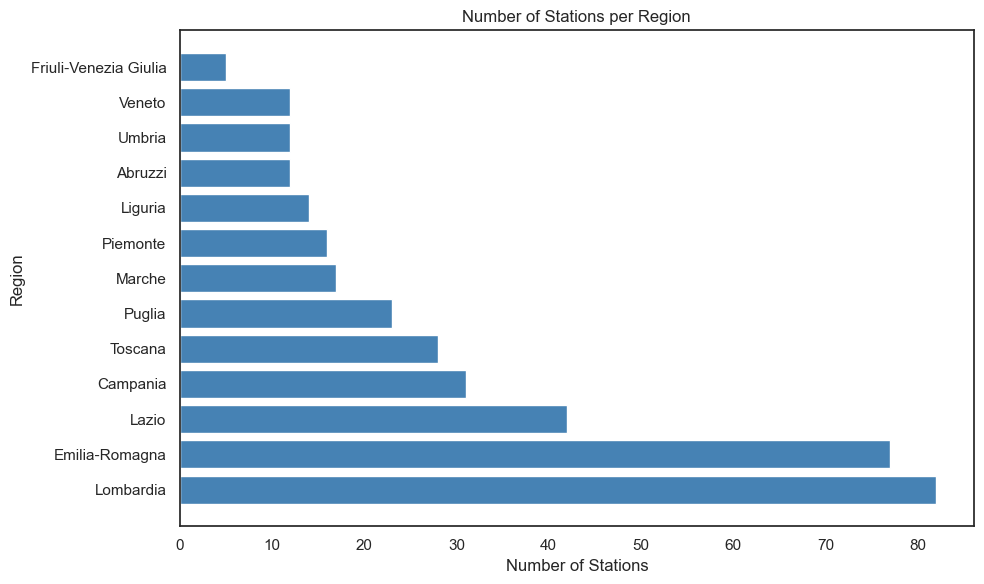

In [224]:
stations_per_region = unique_stations_df.groupby('region')['station_id'].nunique().reset_index()

stations_per_region = stations_per_region.sort_values(by='station_id', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(stations_per_region['region'], stations_per_region['station_id'], color=dark_blue)
plt.title('Number of Stations per Region')
plt.xlabel('Number of Stations')
plt.ylabel('Region')
plt.tight_layout()

plt.show()


In [225]:
stations_per_region = unique_stations_df.groupby('region')['station_id'].nunique().reset_index()

stations_per_region.columns = ['region', 'num_stations']

stations_per_region = stations_per_region.sort_values(by='num_stations', ascending=False)

print(stations_per_region)


                   region  num_stations
6               Lombardia            82
2          Emilia-Romagna            77
4                   Lazio            42
1                Campania            31
10                Toscana            28
9                  Puglia            23
7                  Marche            17
8                Piemonte            16
5                 Liguria            14
0                 Abruzzi            12
11                 Umbria            12
12                 Veneto            12
3   Friuli-Venezia Giulia             5


## Energy Features by Region

By analyzing energy features for each Region, it's possible to understand the correlation between energy consumption, total number of sessions, and cost across regions.

In [227]:
region_aggregates = unique_stations_df.groupby('region').agg(
    total_energy=('totPublicEnergy', 'sum'),
    total_sessions=('totSessions', 'sum'),
    total_cost=('totCost', 'sum')
).reset_index()

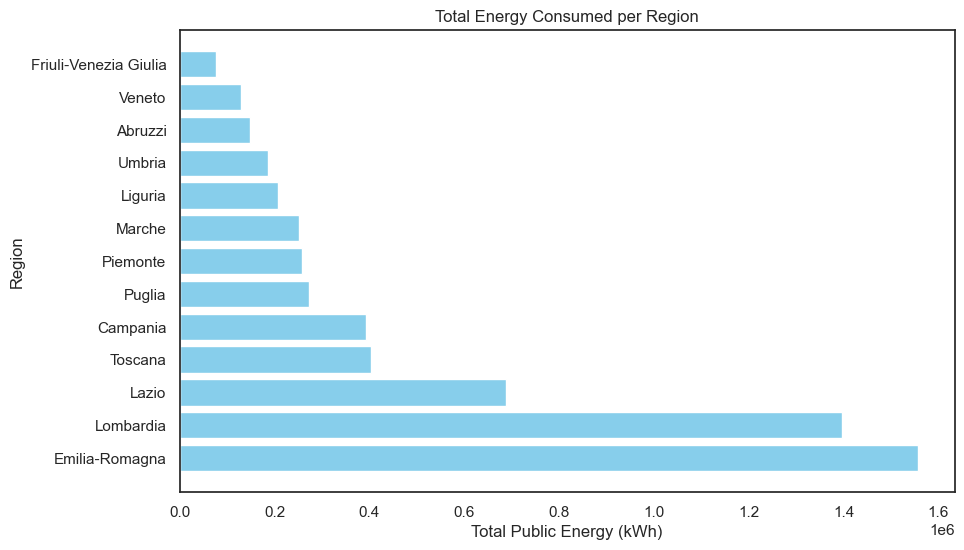

In [232]:
region_aggregates = region_aggregates.sort_values(by='total_energy', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(region_aggregates['region'], region_aggregates['total_energy'], color='skyblue')
plt.title('Total Energy Consumed per Region')
plt.xlabel('Total Public Energy (kWh)')
plt.ylabel('Region')
plt.grid(False)
plt.show()

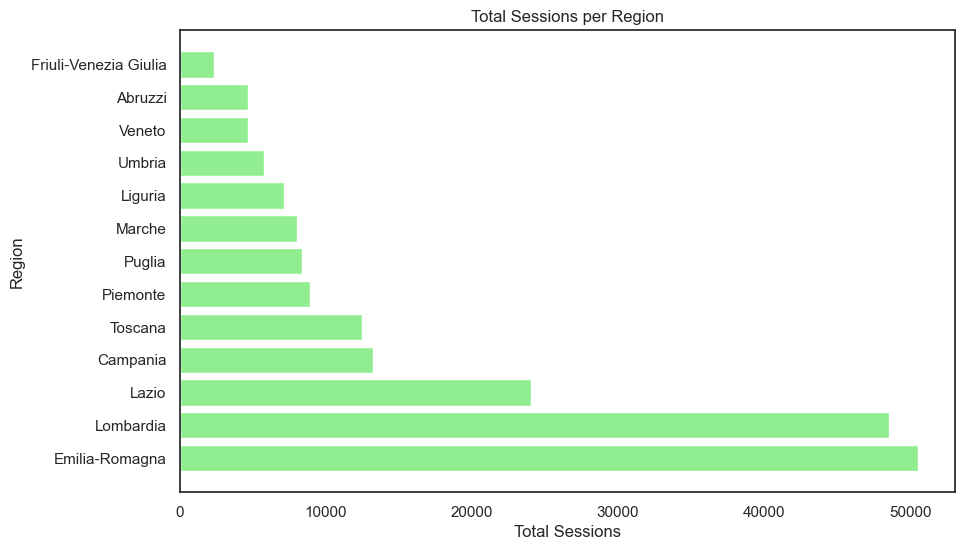

In [233]:
region_aggregates = region_aggregates.sort_values(by='total_sessions', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(region_aggregates['region'], region_aggregates['total_sessions'], color='lightgreen')
plt.title('Total Sessions per Region')
plt.xlabel('Total Sessions')
plt.ylabel('Region')
plt.grid(False)
plt.show()

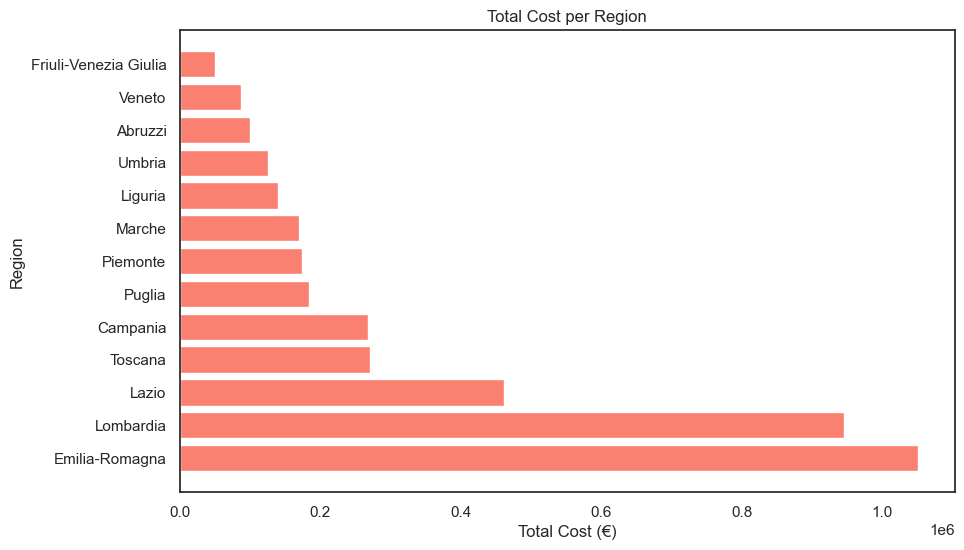

In [234]:
region_aggregates = region_aggregates.sort_values(by='total_cost', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(region_aggregates['region'], region_aggregates['total_cost'], color='salmon')
plt.title('Total Cost per Region')
plt.xlabel('Total Cost (€)')
plt.ylabel('Region')
plt.grid(False)
plt.show()

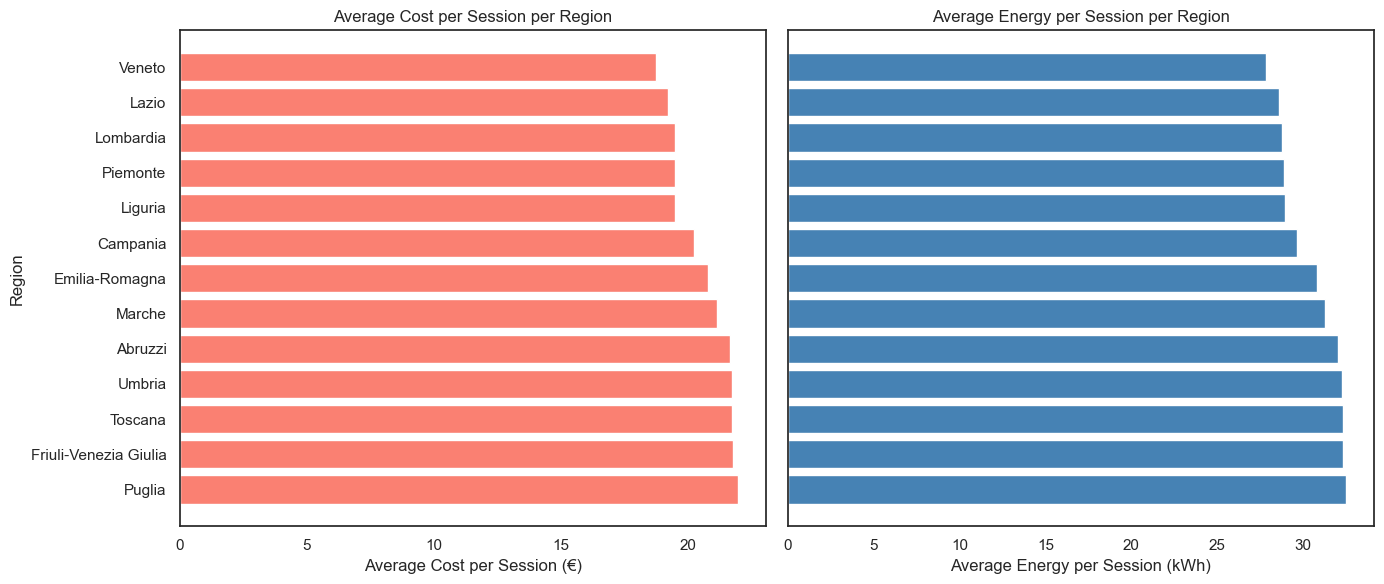

In [231]:
region_aggregates['avg_cost_per_session'] = region_aggregates['total_cost'] / region_aggregates['total_sessions']
region_aggregates['avg_energy_per_session'] = region_aggregates['total_energy'] / region_aggregates['total_sessions']
region_aggregates = region_aggregates.sort_values(by='avg_cost_per_session', ascending=False)

fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

axs[0].barh(region_aggregates['region'], region_aggregates['avg_cost_per_session'], color='salmon')
axs[0].set_title('Average Cost per Session per Region')
axs[0].set_xlabel('Average Cost per Session (€)')
axs[0].set_ylabel('Region')
axs[0].grid(False)
region_aggregates = region_aggregates.sort_values(by='avg_energy_per_session', ascending=False)

axs[1].barh(region_aggregates['region'], region_aggregates['avg_energy_per_session'], color=dark_blue)
axs[1].set_title('Average Energy per Session per Region')
axs[1].set_xlabel('Average Energy per Session (kWh)')
axs[1].grid(False)

plt.tight_layout()
plt.show()


In [129]:
region_aggregates

,region,total_energy,total_sessions,total_cost,avg_cost_per_session,avg_energy_per_session
9,Puglia,272829.4319999999,8396,184274.1000000000,21.9478442115,32.4951681753
10,Toscana,403373.6920000000,12475,270894.8200000000,21.7150156313,32.3345644890
3,Friuli-Venezia Giulia,75788.9000000000,2345,51047.4500000000,21.7686353945,32.3193603412
11,Umbria,187237.3920000000,5809,126069.2700000000,21.7024048890,32.2322933379
0,Abruzzi,149148.6710000000,4655,100811.8700000000,21.6566852846,32.0405308271
7,Marche,251636.0709999999,8054,170095.3900000000,21.1193680159,31.2436144773
2,Emilia-Romagna,1556582.7879999997,50517,1050554.4900000000,20.7960585545,30.8130488350
1,Campania,393176.8840000000,13269,268507.2900000000,20.2356839249,29.6312370186
5,Liguria,207119.0450000000,7160,139565.5400000000,19.4923938547,28.9272409218
8,Piemonte,258306.7280000001,8943,174143.6300000000,19.4726188080,28.8836775131


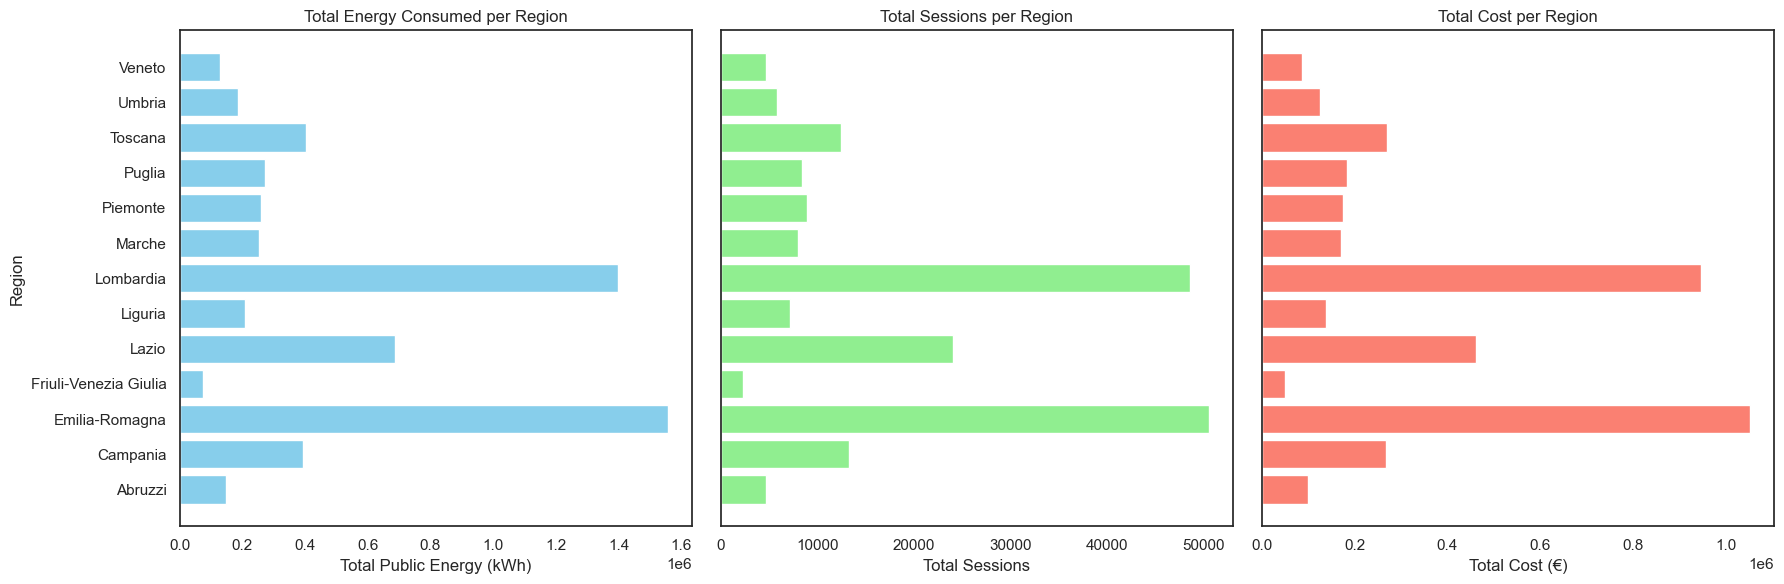

In [130]:
region_aggregates = unique_stations_df.groupby('region').agg(
    total_energy=('totPublicEnergy', 'sum'),
    total_sessions=('totSessions', 'sum'),
    total_cost=('totCost', 'sum')
).reset_index()

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

axs[0].barh(region_aggregates['region'], region_aggregates['total_energy'], color='skyblue')
axs[0].set_title('Total Energy Consumed per Region')
axs[0].set_xlabel('Total Public Energy (kWh)')
axs[0].set_ylabel('Region')
axs[0].grid(False)

axs[1].barh(region_aggregates['region'], region_aggregates['total_sessions'], color='lightgreen')
axs[1].set_title('Total Sessions per Region')
axs[1].set_xlabel('Total Sessions')
axs[1].grid(False)

axs[2].barh(region_aggregates['region'], region_aggregates['total_cost'], color='salmon')
axs[2].set_title('Total Cost per Region')
axs[2].set_xlabel('Total Cost (€)')
axs[2].grid(False)

plt.tight_layout()
plt.show()

region_aggregates_energy_sorted = region_aggregates.sort_values(by='total_energy', ascending=False)

region_aggregates_sessions_sorted = region_aggregates.sort_values(by='total_sessions', ascending=False)

region_aggregates_cost_sorted = region_aggregates.sort_values(by='total_cost', ascending=False)



In areas with higher energy consumption and more charging sessions, costs show a proportional increase. 
This relationship is particularly evident in high-demand regions, highlighting the direct link between charging activity and associated costs.

## Charging Type Analysis

In [235]:
def classify_charging_session(power):
    if power >= 300:
        return 'High Power Charging (HPC)'
    elif 50 <= power < 300:
        return 'Direct Current (DC)'
    else:
        return 'Alternating Current (AC)'

cdr_cleaned['Charging Type'] = cdr_cleaned['Potenza (kW)'].apply(classify_charging_session)

print(cdr_cleaned[['CDR ID', 'Potenza (kW)', 'Charging Type']].sample(10))


         CDR ID   Potenza (kW)              Charging Type
182978  1367244  62.5000000000        Direct Current (DC)
188863  1382089 300.0000000000  High Power Charging (HPC)
45820   1043569 300.0000000000  High Power Charging (HPC)
241973  1618335 300.0000000000  High Power Charging (HPC)
183543  1368974 300.0000000000  High Power Charging (HPC)
227776  1578916 300.0000000000  High Power Charging (HPC)
48122   1048296 300.0000000000  High Power Charging (HPC)
184531  1371804  22.0000000000   Alternating Current (AC)
40513   1031492 300.0000000000  High Power Charging (HPC)
201932  1510182 300.0000000000  High Power Charging (HPC)


In [236]:
print(cdr_cleaned['Charging Type'].value_counts())


Charging Type
High Power Charging (HPC)    276505
Direct Current (DC)           12509
Alternating Current (AC)      10986
Name: count, dtype: int64


In [237]:
unique_evse_ids = cdr_cleaned['EVSE ID'].nunique()

print(f'The number of unique EVSE IDs: {unique_evse_ids}')

The number of unique EVSE IDs: 681


In [238]:
evse_counts = cdr_cleaned['EVSE ID'].value_counts()

evse_duplicates = evse_counts[evse_counts > 1]

print(evse_duplicates)

EVSE ID
IT*F2X*EF2XITA3001*1     2618
IT*F2X*EF2XITA2002*1     2337
IT*F2X*EF2XITA2002*2     2307
IT*F2X*EF2XITA2001*1     2294
IT*F2X*EF2XITD5102*1     2246
IT*F2X*EF2XITA3002*1     2205
IT*F2X*EF2XITA3002*2     2144
IT*F2X*EF2XITD5002*1     2121
IT*F2X*EF2XITA3001*2     2099
IT*F2X*EF2XITD2102*1     2003
IT*F2X*EF2XITLINC01*2    1975
IT*F2X*EF2XITA2102*1     1948
IT*F2X*EF2XITD5001*1     1826
IT*F2X*EF2XITA3102*1     1734
IT*F2X*EF2XITD5002*2     1732
IT*F2X*EF2XITLINC03*2    1728
IT*F2X*EF2XITA2001*2     1708
IT*F2X*EF2XITLINC05*2    1694
IT*F2X*EF2XITI1001*2     1676
IT*F2X*EF2XITLINC04*2    1656
IT*F2X*EF2XITLINC02*2    1651
IT*F2X*EF2XITB4002*1     1649
IT*F2X*EF2XITA1002*1     1610
IT*F2X*EF2XITA1001*1     1604
IT*F2X*EF2XITB4101*1     1603
IT*F2X*EF2XITD2101*1     1575
IT*F2X*EF2XITN1102*1     1573
IT*F2X*EF2XITD5101*1     1568
IT*F2X*EF2XITB4501*1     1565
IT*F2X*EF2XITA1002*2     1524
IT*F2X*EF2XITI1002*1     1519
IT*F2X*EF2XITD5001*2     1507
IT*F2X*EF2XITD5102*2     1504
IT

In [135]:
def get_charging_type(evse_id):
    evse_data = cdr_cleaned[cdr_cleaned['EVSE ID'] == evse_id]
    
    if evse_data.empty:
        return f"No data found for EVSE ID: {evse_id}"
    
    charging_types = evse_data['Charging Type'].unique()
    
    if len(charging_types) > 1:
        return f"EVSE ID {evse_id} has inconsistent charging types: {charging_types}"
    
    return f"EVSE ID {evse_id} is categorized as: {charging_types[0]}"

evse_id = 'IT*F2X*EF2XITO4551*2'
result = get_charging_type(evse_id)
print(result)

EVSE ID IT*F2X*EF2XITO4551*2 is categorized as: Direct Current (DC)


In [136]:
charging_type_counts = cdr_cleaned['Charging Type'].value_counts().reset_index()
charging_type_counts.columns = ['Charging Type', 'Count']

fig = px.bar(charging_type_counts, 
             x='Charging Type', 
             y='Count', 
             title='Number of Charging Sessions per Charging Type', 
             labels={'Charging Type': 'Charging Type', 'Count': 'Number of Sessions'},
             text='Count')

fig.show()

In [137]:
fig = px.pie(charging_type_counts, 
             names='Charging Type', 
             values='Count', 
             title='Proportion of Charging Sessions per Charging Type', 
             hole=0.3)

fig.show()

In [138]:
bubble_data = cdr_cleaned.groupby('Charging Type').agg({'Potenza (kW)': ['sum', 'count']}).reset_index()
bubble_data.columns = ['Charging Type', 'Total Power (kW)', 'Number of Sessions']

fig = px.scatter(bubble_data, 
                 x='Charging Type', 
                 y='Total Power (kW)', 
                 size='Number of Sessions', 
                 color='Charging Type', 
                 title='Bubble Chart of Charging Sessions and Total Power Delivered',
                 size_max=60)

fig.show()



## Charging Activation Trends (2021-2024)

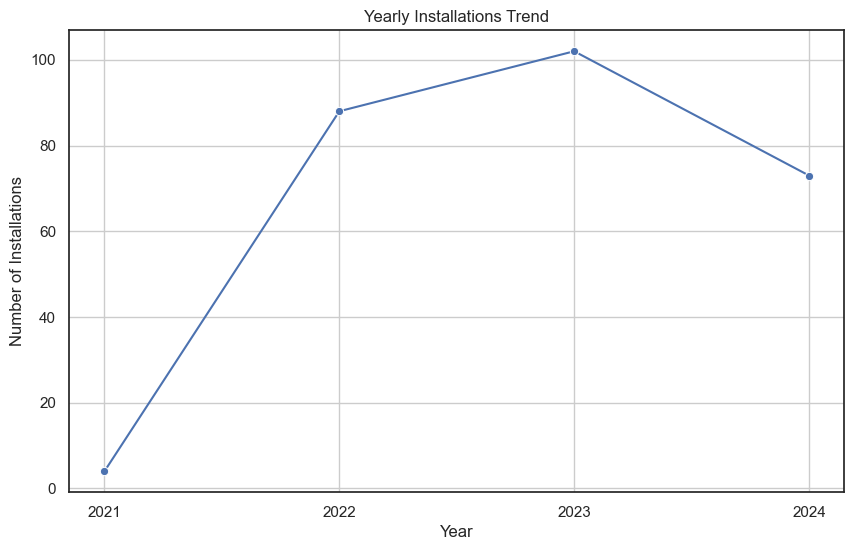

In [140]:
if 'commissioningDate' in hloc_cleaned.columns:
    hloc_cleaned['commissioningDate'] = pd.to_datetime(hloc_cleaned['commissioningDate'], errors='coerce')

    hloc_cleaned['Year'] = hloc_cleaned['commissioningDate'].dt.year

    yearly_installations = (
        hloc_cleaned.groupby('Year')
        .size()
        .reset_index(name='Installations')
    )

    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Year', y='Installations', data=yearly_installations, marker='o')
    plt.title('Yearly Installations Trend')
    plt.xlabel('Year')
    plt.ylabel('Number of Installations')
    plt.xticks(yearly_installations['Year'])
    plt.grid(True)
    plt.show()
else:
    print("'commissioningDate' column not found in the 'hloc_cleaned' dataset.")


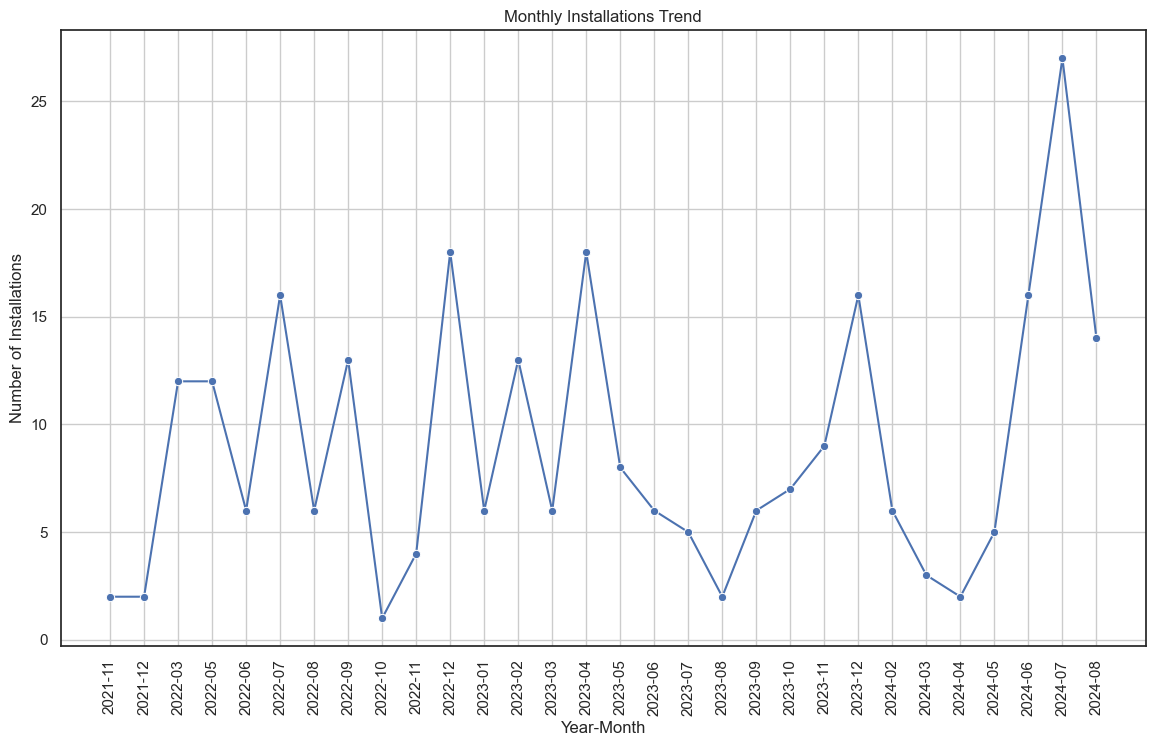

In [141]:
if 'commissioningDate' in hloc_cleaned.columns:
    hloc_cleaned['commissioningDate'] = pd.to_datetime(hloc_cleaned['commissioningDate'], errors='coerce')

    hloc_cleaned['YearMonth'] = hloc_cleaned['commissioningDate'].dt.to_period('M')

    monthly_installations = (
        hloc_cleaned.groupby('YearMonth')
        .size()
        .reset_index(name='Installations')
    )

    monthly_installations['YearMonth'] = monthly_installations['YearMonth'].astype(str)

    plt.figure(figsize=(14, 8))
    sns.lineplot(x='YearMonth', y='Installations', data=monthly_installations, marker='o')
    plt.title('Monthly Installations Trend')
    plt.xlabel('Year-Month')
    plt.ylabel('Number of Installations')
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.show()
else:
    print("'commissioningDate' column not found in the 'hloc_cleaned' dataset.")


## State Of Charge (SOC) Analysis

In [142]:
s1=hses[["chargingSessionGraphData","stackErrors","chargingSessionErrors"]]
print(s1.shape)
s1.head(5)

(13442, 3)


,chargingSessionGraphData,stackErrors,chargingSessionErrors
0,"[{'currentEv': 0.0, 'currentEvse': 0.0, 'curre...",[],"[{'cause': 'loganalyze', 'chargingSessionError..."
1,"[{'currentEv': 1.0, 'currentEvse': 0.0, 'curre...",[],"[{'cause': 'loganalyze', 'chargingSessionError..."
2,"[{'currentEv': 1.0, 'currentEvse': 0.0, 'curre...",[],"[{'cause': 'loganalyze', 'chargingSessionError..."
3,"[{'currentEv': 0.0, 'currentEvse': 0.1, 'curre...",[],"[{'cause': 'loganalyze', 'chargingSessionError..."
4,"[{'currentEv': 4.0, 'currentEvse': 0.0, 'curre...",[],"[{'cause': 'loganalyze', 'chargingSessionError..."


In [143]:
def process_charging_session(session_data):
    if len(session_data) == 0:
        return pd.Series({
            'start_date': None,
            'end_date': None,
            'session_duration': None,
            'soc_start': None,
            'soc_end': None,
            'max_current_ev': None,
            'max_voltage_ev': None,
            'average_resistance': None
        })

    start_date = session_data[0]['date']
    end_date = session_data[-1]['date']
    
    start_time = datetime.strptime(start_date, "%Y-%m-%d %H:%M:%S.%f")
    end_time = datetime.strptime(end_date, "%Y-%m-%d %H:%M:%S.%f")
    session_duration = (end_time - start_time).total_seconds()
    
    soc_start = session_data[0]['soc']
    soc_end = session_data[-1]['soc']
    
    max_current_ev = max(entry['currentEv'] for entry in session_data if entry['currentEv'] is not None)
    max_voltage_ev = max(entry['voltageEv'] for entry in session_data if entry['voltageEv'] is not None)
    
    resistances = [entry['resistance'] for entry in session_data if entry['resistance'] is not None]
    if len(resistances) > 0:
        average_resistance = sum(resistances) / len(resistances)
    else:
        average_resistance = None

    return pd.Series({
        'start_date': start_date,
        'end_date': end_date,
        'session_duration': session_duration,
        'soc_start': soc_start,
        'soc_end': soc_end,
        'max_current_ev': max_current_ev,
        'max_voltage_ev': max_voltage_ev,
        'average_resistance': average_resistance
    })

s1[['start_date', 'end_date', 'session_duration', 'soc_start', 'soc_end', 'max_current_ev', 'max_voltage_ev', 'average_resistance']] = s1['chargingSessionGraphData'].apply(process_charging_session)

/var/folders/n5/yvhs1y856g10wj7dfwsql5h40000gn/T/ipykernel_85151/2780839296.py:53: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/n5/yvhs1y856g10wj7dfwsql5h40000gn/T/ipykernel_85151/2780839296.py:53: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/n5/yvhs1y856g10wj7dfwsql5h40000gn/T/ipykernel_85151/2780839296.py:53: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [144]:
def process_stack_errors(error_data):
    if len(error_data) == 0:
        return pd.Series({
            'error_position': None,
            'error_text': None,
            'stack_position': None,
            'stack_serial_number': None,
            'error_timestamp': None
        })

    first_error = error_data[0] 

    error_position = first_error.get('errorPosition', None)
    error_text = first_error.get('errorText', None)
    stack_position = first_error.get('stackPosition', None)
    stack_serial_number = first_error.get('stackSerialNumber', None)
    error_timestamp = first_error.get('ts', None)

    return pd.Series({
        'error_position': error_position,
        'error_text': error_text,
        'stack_position': stack_position,
        'stack_serial_number': stack_serial_number,
        'error_timestamp': error_timestamp
    })

s1[['error_position', 'error_text', 'stack_position', 'stack_serial_number', 'error_timestamp']] = s1['stackErrors'].apply(process_stack_errors)

/var/folders/n5/yvhs1y856g10wj7dfwsql5h40000gn/T/ipykernel_85151/4020729161.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/n5/yvhs1y856g10wj7dfwsql5h40000gn/T/ipykernel_85151/4020729161.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/n5/yvhs1y856g10wj7dfwsql5h40000gn/T/ipykernel_85151/4020729161.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [145]:
def process_session_error(error_data):
    if len(error_data) == 0:
        return pd.Series({
            'cause_list': None,
            'number_of_errors': 0,
            'unique_error_codes': None,
            'error_code_counts': {}
        })

    causes = list(set(entry['cause'] for entry in error_data if entry['cause'] is not None))
    
    number_of_errors = len([entry['dateTime'] for entry in error_data if entry['dateTime'] is not None])
    
    error_code_counts = {}
    for entry in error_data:
        if entry['hycErrorCode'] is not None:
            code = entry['hycErrorCode']
            if code in error_code_counts:
                error_code_counts[code] += 1
            else:
                error_code_counts[code] = 1

    error_codes = list(error_code_counts.keys())

    return pd.Series({
        'cause_list': causes,
        'number_of_errors': number_of_errors,
        'unique_error_codes': error_codes,
        'error_code_counts': error_code_counts
    })

s1[['cause_list', 'number_of_errors', 'unique_error_codes', 'error_code_counts']] = s1['chargingSessionErrors'].apply(process_session_error)

/var/folders/n5/yvhs1y856g10wj7dfwsql5h40000gn/T/ipykernel_85151/878543699.py:38: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/n5/yvhs1y856g10wj7dfwsql5h40000gn/T/ipykernel_85151/878543699.py:38: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/n5/yvhs1y856g10wj7dfwsql5h40000gn/T/ipykernel_85151/878543699.py:38: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [146]:
display(s1.head())

,chargingSessionGraphData,stackErrors,chargingSessionErrors,start_date,end_date,session_duration,soc_start,soc_end,max_current_ev,max_voltage_ev,average_resistance,error_position,error_text,stack_position,stack_serial_number,error_timestamp,cause_list,number_of_errors,unique_error_codes,error_code_counts
0,"[{'currentEv': 0.0, 'currentEvse': 0.0, 'curre...",[],"[{'cause': 'loganalyze', 'chargingSessionError...",2024-07-14 06:01:57.926,2024-07-14 06:26:31.963,1474.0370000000,37.0000000000,87.0000000000,367.5000000000,408.0000000000,1243.7131147541,NaN,None,NaN,None,None,[loganalyze],3,"[PostAnalysis_User_stop_charger_button, PostAn...","{'PostAnalysis_User_stop_charger_button': 1, '..."
1,"[{'currentEv': 1.0, 'currentEvse': 0.0, 'curre...",[],"[{'cause': 'loganalyze', 'chargingSessionError...",2024-07-14 06:01:58.589,2024-07-14 06:24:52.260,1373.6710000000,48.0000000000,78.0000000000,207.5000000000,421.4000000000,1767.0294117647,NaN,None,NaN,None,None,[loganalyze],3,"[PostAnalysis_User_stop_charger_button, PostAn...","{'PostAnalysis_User_stop_charger_button': 1, '..."
2,"[{'currentEv': 1.0, 'currentEvse': 0.0, 'curre...",[],"[{'cause': 'loganalyze', 'chargingSessionError...",2024-07-14 06:02:17.047,2024-07-14 06:44:24.440,2527.3930000000,28.0000000000,91.0000000000,439.4000000000,473.0000000000,1528.1060126582,NaN,None,NaN,None,None,[loganalyze],3,"[PostAnalysis_User_stop_charger_button, PostAn...","{'PostAnalysis_User_stop_charger_button': 1, '..."
3,"[{'currentEv': 0.0, 'currentEvse': 0.1, 'curre...",[],"[{'cause': 'loganalyze', 'chargingSessionError...",2024-07-14 06:03:16.797,2024-07-14 06:19:52.513,995.7160000000,47.0000000000,80.0000000000,372.6000000000,408.0000000000,936.7591836735,NaN,None,NaN,None,None,[loganalyze],3,"[PostAnalysis_user_stop_ev_side, PostAnalysis_...","{'PostAnalysis_user_stop_ev_side': 1, 'PostAna..."
4,"[{'currentEv': 4.0, 'currentEvse': 0.0, 'curre...",[],"[{'cause': 'loganalyze', 'chargingSessionError...",2024-07-14 06:03:49.835,2024-07-14 06:36:18.077,1948.2420000000,23.0000000000,83.0000000000,300.0000000000,375.0000000000,768.3347547974,NaN,None,NaN,None,None,[loganalyze],3,"[PostAnalysis_User_stop_charger_button, PostAn...","{'PostAnalysis_User_stop_charger_button': 1, '..."


In [147]:
s1[s1["soc_start"]>=s1["soc_end"]].shape

(66, 20)

In [148]:
hses[hses["session.socStart"]>=hses["session.socStop"]].shape

(1393, 47)

In [149]:
s1['chargingSessionGraphData'] = s1['chargingSessionGraphData'].apply(lambda x: str(x) if isinstance(x, (list, np.ndarray)) else x)
s1['stackErrors'] = s1['stackErrors'].apply(lambda x: str(x) if isinstance(x, (list, np.ndarray)) else x)
s1['chargingSessionErrors'] = s1['chargingSessionErrors'].apply(lambda x: str(x) if isinstance(x, (list, np.ndarray)) else x)

hses['chargingSessionGraphData'] = hses['chargingSessionGraphData'].apply(lambda x: str(x) if isinstance(x, (list, np.ndarray)) else x)
hses['stackErrors'] = hses['stackErrors'].apply(lambda x: str(x) if isinstance(x, (list, np.ndarray)) else x)
hses['chargingSessionErrors'] = hses['chargingSessionErrors'].apply(lambda x: str(x) if isinstance(x, (list, np.ndarray)) else x)

s1 = s1.merge(hses[['chargingSessionGraphData', 'stackErrors', 'chargingSessionErrors', 'session.socStart', 'session.socStop']],
                     on=['chargingSessionGraphData', 'stackErrors', 'chargingSessionErrors'],
                     how='left')

/var/folders/n5/yvhs1y856g10wj7dfwsql5h40000gn/T/ipykernel_85151/2544408756.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/n5/yvhs1y856g10wj7dfwsql5h40000gn/T/ipykernel_85151/2544408756.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/n5/yvhs1y856g10wj7dfwsql5h40000gn/T/ipykernel_85151/2544408756.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [150]:
mismatch_count = (s1['session.socStop'] != s1['soc_end']).sum()
mismatch_count2 = (s1['session.socStart'] != s1['soc_start']).sum()
print(f"Number of Non-Matching Values \nstart: {mismatch_count}             stop:{mismatch_count2}")

Number of Non-Matching Values 
start: 5968             stop:5397


There is not always exact correlation between soc_start, soc_end and session.socStart, session.socStop

In [151]:
s1.columns

Index(['chargingSessionGraphData', 'stackErrors', 'chargingSessionErrors',
       'start_date', 'end_date', 'session_duration', 'soc_start', 'soc_end',
       'max_current_ev', 'max_voltage_ev', 'average_resistance',
       'error_position', 'error_text', 'stack_position', 'stack_serial_number',
       'error_timestamp', 'cause_list', 'number_of_errors',
       'unique_error_codes', 'error_code_counts', 'session.socStart',
       'session.socStop'],
      dtype='object')

/var/folders/n5/yvhs1y856g10wj7dfwsql5h40000gn/T/ipykernel_85151/1266396596.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




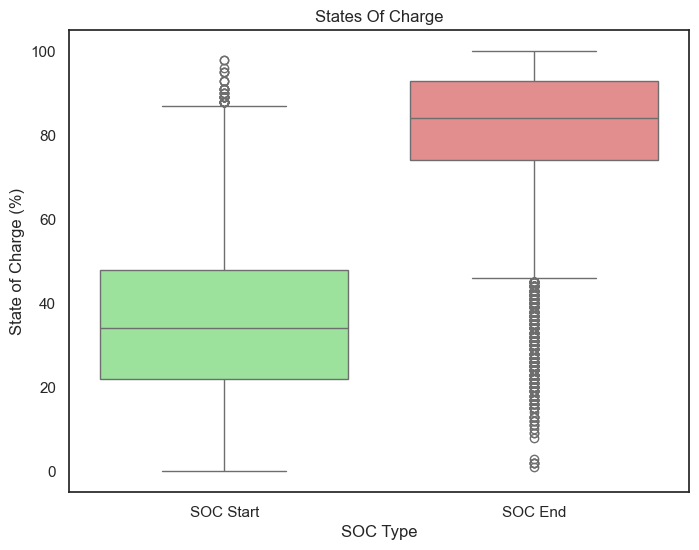

In [152]:
df_clean = s1.dropna(subset=['soc_start', 'soc_end'])

data_for_boxplot = pd.DataFrame({
    'SOC Start': df_clean['soc_start'],
    'SOC End': df_clean['soc_end']
})

data_melted = pd.melt(data_for_boxplot, var_name='SOC Type', value_name='State of Charge')

plt.figure(figsize=(8, 6))
sns.boxplot(x='SOC Type', y='State of Charge', data=data_melted, palette=['lightgreen', 'lightcoral'])

plt.title('States Of Charge')
plt.ylabel('State of Charge (%)')
plt.show()

## Charging Session Duration

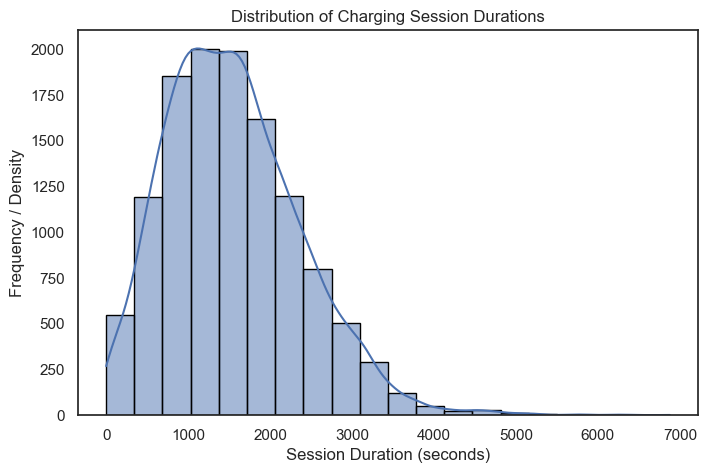

In [153]:
plt.figure(figsize=(8, 5))
sns.histplot(s1['session_duration'], bins=20, kde=True, edgecolor='black')
plt.xlabel('Session Duration (seconds)')
plt.ylabel('Frequency / Density')
plt.title('Distribution of Charging Session Durations')
plt.show()

## Insurance and Warranty Analysis

/var/folders/n5/yvhs1y856g10wj7dfwsql5h40000gn/T/ipykernel_85151/3352842791.py:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/n5/yvhs1y856g10wj7dfwsql5h40000gn/T/ipykernel_85151/3352842791.py:28: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



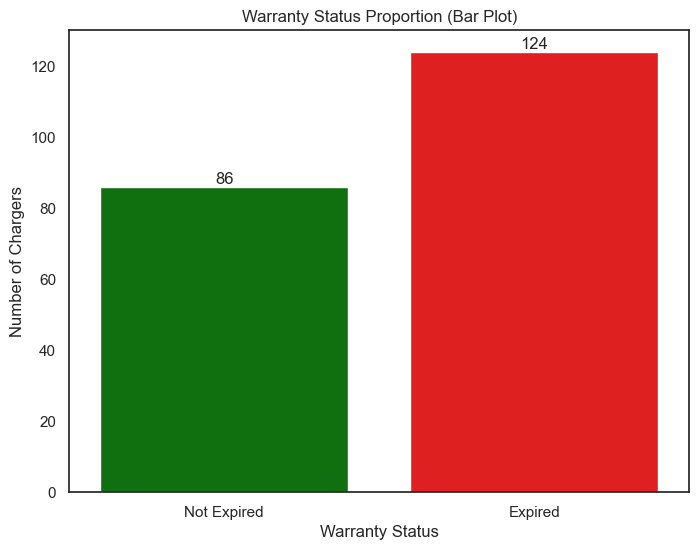

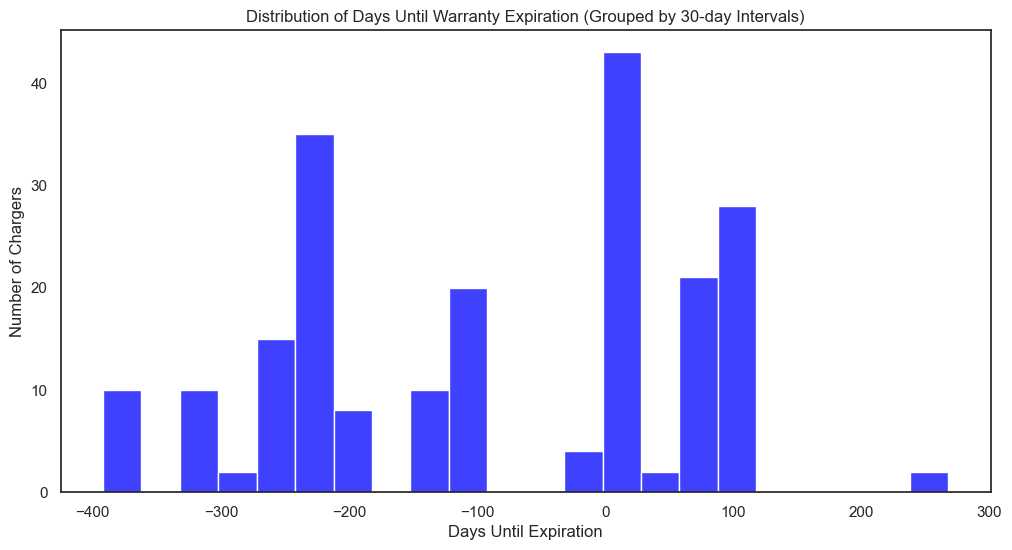

In [154]:
file_path = './dataset/cleaned_serial_numbers.csv'

df = pd.read_csv(file_path)

df['commissioningDate'] = pd.to_datetime(df['commissioningDate'], errors='coerce')
df['warrantyExpiration'] = pd.to_datetime(df['warrantyExpiration'], errors='coerce')

df['WarrantyExpired'] = df['warrantyExpiration'] < pd.Timestamp.today()

df['DaysUntilExpiration'] = (df['warrantyExpiration'] - pd.Timestamp.today()).dt.days

sns.set_theme(style="white")

plt.figure(figsize=(8, 6))
ax = sns.countplot(x='WarrantyExpired', data=df, palette=['green', 'red'])

plt.title('Warranty Status Proportion (Bar Plot)')
plt.xlabel('Warranty Status')
plt.ylabel('Number of Chargers')
ax.set_xticklabels(['Not Expired', 'Expired'])

for container in ax.containers:
    ax.bar_label(container, label_type='edge')

plt.grid(False) 
plt.show()

bin_width = 30
bins = range(int(df['DaysUntilExpiration'].min()), int(df['DaysUntilExpiration'].max()) + bin_width, bin_width)


plt.figure(figsize=(12, 6))
sns.histplot(df['DaysUntilExpiration'], bins=bins, kde=False, color='blue')
plt.title('Distribution of Days Until Warranty Expiration (Grouped by 30-day Intervals)')
plt.xlabel('Days Until Expiration')
plt.ylabel('Number of Chargers')

plt.grid(False)
plt.show()



## Energy Distribution Analysis in EV Charging

In [155]:
data = hloc_cleaned

total_rows = data.shape[0]
total_columns = data.shape[1]

print(f"Number of rows: {total_rows}")
print(f"Number of columns: {total_columns}")

columns_to_show_new = [
    'commissioningDate', 
    'notServiceable', 
    'hwVersion', 
    'status_status', 
    'isActive', 
    'corporationName', 
    'finishedEol', 
    'warrantyExpiration'
]

missing_columns = [col for col in columns_to_show_new if col not in data.columns]
if missing_columns:
    print(f"Warning: The following columns are missing from the DataFrame: {missing_columns}")
else:
    selected_data_new = data[columns_to_show_new]
    print("Selected columns preview:")
    print(selected_data_new.head())



Number of rows: 374
Number of columns: 63
Selected columns preview:
  commissioningDate  notServiceable  hwVersion status_status  isActive  \
0        2023-12-06           False          4      Charging      True   
1        2023-03-02           False          4     Available      True   
2        2024-08-09           False          4     Available      True   
3        2023-07-04           False          4     Available      True   
4               NaT           False          4   Unavailable     False   

    corporationName  finishedEol   warrantyExpiration  
0  Free To X S.p.A.         True  2025-03-07T00:00:00  
1  Free To X S.p.A.         True  2024-12-02T00:00:00  
2  Free To X S.p.A.         True                  NaN  
3  Free To X S.p.A.         True  2025-02-08T00:00:00  
4  Free To X S.p.A.         True                  NaN  


In [156]:
columns_to_show = ['gpsLat', 'gpsLong', 'locationStreet', 'locationTown', 'locationZipCode', 'locationProvince', 'locationCountry',
                   'commissioningDate', 'notServiceable', 'hwVersion', 'status_status', 'isActive', 'corporationName', 'softwareVersion']

data[columns_to_show] = data[columns_to_show].fillna("//")

italy_map = folium.Map(location=[41.8719, 12.5674], zoom_start=6)

def create_geo_popup(row):
    geo_info = f"""
    <b>Latitudine:</b> {row['gpsLat']}<br>
    <b>Longitudine:</b> {row['gpsLong']}<br>
    <b>Indirizzo:</b> {row['locationStreet']}<br>
    <b>Città:</b> {row['locationTown']}<br>
    <b>Codice Postale:</b> {row['locationZipCode']}<br>
    <b>Provincia:</b> {row['locationProvince']}<br>
    <b>Paese:</b> {row['locationCountry']}<br>
    """
    return geo_info

def create_status_popup(row):

    if row['notServiceable'] == 'Yes':
        not_serviceable_text = 'Non riparabile'
    else:
        not_serviceable_text = row['notServiceable']

    status_info = f"""
    <b>Data di messa in servizio:</b> {row['commissioningDate']}<br>
    <b>Non riparabile:</b> {not_serviceable_text}<br>
    <b>Versione hardware:</b> {row['hwVersion']}<br>
    <b>Status del caricatore:</b> {row['status_status']}<br>
    <b>Attivo:</b> {row['isActive']}<br>
    <b>Nome della società:</b> {row['corporationName']}<br>
    <b>Versione Software:</b> {row['softwareVersion']}<br>
    <b>Fine vita utile:</b> {row['finishedEol']}
    """
    return status_info

for index, row in data.iterrows():
    if row['gpsLat'] != "//" and row['gpsLong'] != "//":
        if row['status_status'] == 'Unavailable':
            icon_color = 'red'
        elif row['notServiceable'] == 'True':
            icon_color = 'black'
        elif row['status_status'] == 'Charging':
            icon_color = 'yellow'
        else:
            icon_color = 'green'

        geo_popup = create_geo_popup(row)
        status_popup = create_status_popup(row)

        folium.Marker(
            location=[row['gpsLat'], row['gpsLong']],
            popup=folium.Popup(f"{geo_popup}<br><br>{status_popup}", max_width=300),
            icon=folium.Icon(color=icon_color, icon='bolt', prefix='fa')
        ).add_to(italy_map)

italy_map

/var/folders/n5/yvhs1y856g10wj7dfwsql5h40000gn/T/ipykernel_85151/3934286921.py:64: UserWarning:

color argument of Icon should be one of: {'darkgreen', 'black', 'lightgray', 'red', 'gray', 'lightgreen', 'beige', 'darkblue', 'purple', 'lightred', 'green', 'white', 'cadetblue', 'darkpurple', 'darkred', 'pink', 'lightblue', 'blue', 'orange'}.



Noted on the map just above that if we shift our attention towards the ocean, we will find several chargers (clearly outliers) positioned in the middle of the sea. These were plotted because they also had both longitude and latitude values, but due to the lack of decimals, their positions are distorted and therefore not useful for our analysis.

In [157]:
columns_to_show = ['gpsLat', 'gpsLong', 'locationStreet', 'locationTown', 'locationZipCode', 'locationProvince', 'locationCountry',
                   'commissioningDate', 'notServiceable', 'hwVersion', 'status_status', 'isActive', 'corporationName', 'softwareVersion']

data[columns_to_show] = data[columns_to_show].fillna("//")

italy_map = folium.Map(location=[41.8719, 12.5674], zoom_start=6)

def create_geo_popup(row):
    geo_info = f"""
    <b>Latitude:</b> {row['gpsLat']}<br>
    <b>Longitude:</b> {row['gpsLong']}<br>
    <b>Address:</b> {row['locationStreet']}<br>
    <b>City:</b> {row['locationTown']}<br>
    <b>Postal Code:</b> {row['locationZipCode']}<br>
    <b>Province:</b> {row['locationProvince']}<br>
    <b>Country:</b> {row['locationCountry']}<br>
    """
    return geo_info

def create_status_popup(row):
    not_serviceable_text = 'Not Serviceable' if row['notServiceable'] == 'Yes' else row['notServiceable']

    status_info = f"""
    <b>Commissioning Date:</b> {row['commissioningDate']}<br>
    <b>Not Serviceable:</b> {not_serviceable_text}<br>
    <b>Hardware Version:</b> {row['hwVersion']}<br>
    <b>Charger Status:</b> {row['status_status']}<br>
    <b>Active:</b> {row['isActive']}<br>
    <b>Company Name:</b> {row['corporationName']}<br>
    <b>Software Version:</b> {row['softwareVersion']}<br>
    """
    return status_info

for index, row in data.iterrows():
    if row['gpsLat'] != "//" and row['gpsLong'] != "//":
        if isinstance(row['gpsLat'], (int, float)) and isinstance(row['gpsLong'], (int, float)):
            lat_is_valid = len(str(row['gpsLat']).split('.')[1]) > 1
            long_is_valid = len(str(row['gpsLong']).split('.')[1]) > 1

            if lat_is_valid and long_is_valid:
                if row['status_status'] == 'Unavailable':
                    icon_color = 'red'
                elif row['notServiceable'] == 'True':
                    icon_color = 'black'
                elif row['status_status'] == 'Charging':
                    icon_color = 'yellow'
                else:
                    icon_color = 'green'

                geo_popup = create_geo_popup(row)
                status_popup = create_status_popup(row)

                folium.Marker(
                    location=[row['gpsLat'], row['gpsLong']],
                    popup=folium.Popup(f"{geo_popup}<br><br>{status_popup}", max_width=300),
                    icon=folium.Icon(color=icon_color, icon='bolt', prefix='fa')
                ).add_to(italy_map)
italy_map

/var/folders/n5/yvhs1y856g10wj7dfwsql5h40000gn/T/ipykernel_85151/2479158870.py:66: UserWarning:

color argument of Icon should be one of: {'darkgreen', 'black', 'lightgray', 'red', 'gray', 'lightgreen', 'beige', 'darkblue', 'purple', 'lightred', 'green', 'white', 'cadetblue', 'darkpurple', 'darkred', 'pink', 'lightblue', 'blue', 'orange'}.



In [158]:
def has_one_decimal_place(value):
    if isinstance(value, (int, float)) and '.' in str(value):
        decimal_places = len(str(value).split('.')[1])
        return decimal_places == 1
    return False

outliers = data[(data['gpsLat'].apply(has_one_decimal_place)) | (data['gpsLong'].apply(has_one_decimal_place))]

outliers_count = outliers.shape[0]

print(f"Numero di caricabatterie rimossi (outliers): {outliers_count}")

Numero di caricabatterie rimossi (outliers): 31


## Top 10 Charging Errors Analysis

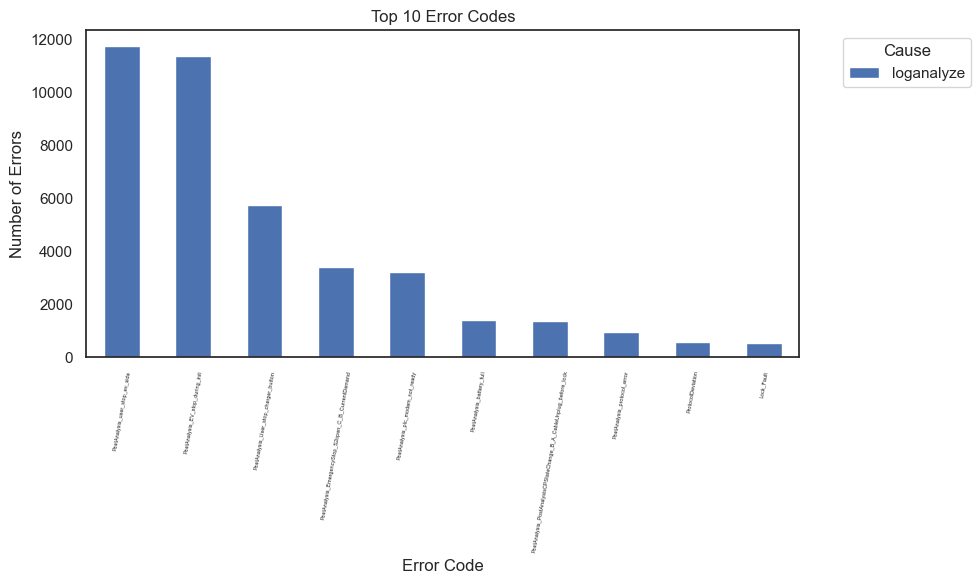

error_code
PostAnalysis_user_stop_ev_side                                        11754
PostAnalysis_EV_stop_during_init                                      11379
PostAnalysis_User_stop_charger_button                                  5749
PostAnalysis_EmergencyStop_S2open_C_B_CurrentDemand                    3409
PostAnalysis_plc_modem_not_ready                                       3217
PostAnalysis_battery_full                                              1413
PostAnalysis_PostAnalysisCPStateChange_B_A_CableUnplug_before_lock     1358
PostAnalysis_protocol_error                                             954
ProtocolDeviation                                                       579
Lock_Fault                                                              547
Name: count, dtype: int64


In [159]:
s1['cause_list'] = s1['cause_list'].apply(lambda x: x if isinstance(x, list) else [])

s1_exploded = s1.explode('cause_list')

error_data = []
for idx, row in s1_exploded.iterrows():
    if isinstance(row['error_code_counts'], dict):
        for code, count in row['error_code_counts'].items():
            error_data.append({
                'cause_list': row['cause_list'],
                'error_code': code,
                'count': count
            })

error_df = pd.DataFrame(error_data)

total_error_counts = error_df.groupby('error_code')['count'].sum()

top_10_errors = total_error_counts.nlargest(10).index

error_df_top_10 = error_df[error_df['error_code'].isin(top_10_errors)]

error_summary_top_10 = error_df_top_10.groupby(['error_code', 'cause_list'])['count'].sum().unstack(fill_value=0)

error_summary_top_10 = error_summary_top_10.loc[total_error_counts.nlargest(10).index]

error_summary_top_10.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.xlabel('Error Code')
plt.ylabel('Number of Errors')
plt.title('Top 10 Error Codes')
plt.xticks(rotation=80, fontsize=4)
plt.legend(title='Cause', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

total_error_counts = error_df.groupby('error_code')['count'].sum()
top_10_errors = total_error_counts.nlargest(10)
print(top_10_errors)

## Session Analysis Local/Not Local

In [160]:
energy_columns = pdr_loc_cleaned[['totEnergy', 'totEnergyLocal', 'totEnergyNotLocal']]

pd.set_option('display.float_format', '{:.10f}'.format)

display(energy_columns.head())





,totEnergy,totEnergyLocal,totEnergyNotLocal
0,4195.0810000000,0.0000000000,4064.3250000000
1,1273.4410000000,0.0000000000,1256.9260000000
2,2097.3080000000,0.0000000000,2064.7480000000
3,40645.6679999999,0.0000000000,40080.5559999999
4,36914.2520000000,0.0000000000,36058.1780000000


In [161]:
unique_totEnergy_count = pdr_loc_cleaned['totEnergy'].nunique()

unique_totEnergyLocal_count = pdr_loc_cleaned['totEnergyLocal'].nunique()

unique_totEnergyNotLocal_count = pdr_loc_cleaned['totEnergyNotLocal'].nunique()

print(f"Count of unique values in 'totEnergy': {unique_totEnergy_count}")
print(f"Count of unique values in 'totEnergyLocal': {unique_totEnergyLocal_count}")
print(f"Count of unique values in 'totEnergyNotLocal': {unique_totEnergyNotLocal_count}")


Count of unique values in 'totEnergy': 824
Count of unique values in 'totEnergyLocal': 3
Count of unique values in 'totEnergyNotLocal': 817


## Tend on Station's Features (Count, Energy X Station, Date, Cost)

In [162]:
joshua = unique_stations_df[["station_id", "station_city", "station_coordinates_lat", "station_coordinates_lon", "plugs", "sessions", "region"]]

def extract_plugs_info(plug_str):
    try:
        plug_list = ast.literal_eval(plug_str)
        if not plug_list:
            return {}
        elif isinstance(plug_list, list) and len(plug_list) == 1:
            return plug_list[0]
        else:
            combined_dict = {}
            for d in plug_list:
                combined_dict.update(d)
            return combined_dict
    except (ValueError, SyntaxError):
        return {}

plugs_df = joshua['plugs'].apply(extract_plugs_info).apply(pd.Series)

joshua = pd.concat([joshua, plugs_df], axis=1)

def extract_sessions_info(session_str):
    try:
        session_list = ast.literal_eval(session_str)
        if not session_list:
            return {}
        else:
            session_dict = {}
            for i, session in enumerate(session_list[:9]):
                idx = i + 1 
                session_dict[f'count_{idx}'] = session.get('count')
                session_dict[f'energy_{idx}'] = session.get('energy')
                session_dict[f'date_{idx}'] = session.get('date')
                session_dict[f'cost_{idx}'] = session.get('cost')
            return session_dict
    except (ValueError, SyntaxError):
        return {}

sessions_df = joshua['sessions'].apply(extract_sessions_info).apply(pd.Series)

joshua = pd.concat([joshua, sessions_df], axis=1)

display(joshua.head(5))


,station_id,station_city,station_coordinates_lat,station_coordinates_lon,plugs,sessions,region,max_electric_power,max_voltage,power_type_id,plug_type_id,plug_format_id,type,format,count_1,energy_1,date_1,cost_1,count_2,energy_2,date_2,cost_2,count_3,energy_3,date_3,cost_3,count_4,energy_4,date_4,cost_4,count_5,energy_5,date_5,cost_5,count_6,energy_6,date_6,cost_6,count_7,energy_7,date_7,cost_7,count_8,energy_8,date_8,cost_8,count_9,energy_9,date_9,cost_9
0,385079,Fiorenzuola d'Arda,44.9626600000,9.9042600000,"[{'max_electric_power': 62500, 'max_voltage': ...","[{'count': 19, 'energy': 323.54699999999997, '...",Emilia-Romagna,62500,500,3,21,2,COMBO,CABLE,19.0000000000,323.5470000000,2024-01,177.93,14.0000000000,325.2190000000,2024-02,178.87,14.0000000000,287.8170000000,2024-03,158.31,25.0000000000,543.8580000000,2024-04,299.07,27.0000000000,497.3210000000,2024-05,273.53,32.0000000000,593.2140000000,2024-06,327.29,36.0000000000,854.2650000000,2024-07,474.35,32.0000000000,710.9700000000,2024-08,391.04,2.0000000000,58.8700000000,2024-09,32.38
3,578546,Savignano sul Rubicone,44.1169220000,12.4090150000,"[{'max_electric_power': 300000, 'max_voltage':...","[{'count': 111, 'energy': 3728.0720000000015, ...",Emilia-Romagna,300000,600,3,21,2,COMBO,CABLE,111.0000000000,3728.0720000000,2024-01,2535.10,95.0000000000,3188.3520000000,2024-02,2168.07,103.0000000000,3235.2200000000,2024-03,2199.94,116.0000000000,3794.1360000000,2024-04,2580.01,122.0000000000,4081.1440000000,2024-05,2775.19,154.0000000000,4747.6120000000,2024-06,3228.35,211.0000000000,6895.0840000000,2024-07,4688.62,289.0000000000,10329.9840000000,2024-08,7025.87,19.0000000000,646.0640000000,2024-09,439.31
5,385083,Caponago,45.5758900000,9.3933600000,"[{'max_electric_power': 62500, 'max_voltage': ...","[{'count': 16, 'energy': 293.1700000000001, 'd...",Lombardia,62500,500,3,21,2,COMBO,CABLE,16.0000000000,293.1700000000,2024-01,161.23,18.0000000000,325.4630000000,2024-02,179.01,8.0000000000,80.9320000000,2024-03,44.52,20.0000000000,374.3670000000,2024-04,205.91,20.0000000000,303.6170000000,2024-05,166.99,20.0000000000,309.2000000000,2024-06,170.06,22.0000000000,356.5610000000,2024-07,196.13,25.0000000000,422.5020000000,2024-08,232.39,NaN,NaN,NaN,NaN
8,480502,Giove,42.4991700000,12.3109600000,"[{'max_electric_power': 50000, 'max_voltage': ...","[{'count': 6, 'energy': 88.094, 'date': '2024-...",Umbria,50000,1000,3,1,2,CHADEMO,CABLE,6.0000000000,88.0940000000,2024-01,48.45,6.0000000000,76.0510000000,2024-02,41.82,1.0000000000,2.2260000000,2024-03,1.22,5.0000000000,68.0040000000,2024-04,37.40,2.0000000000,27.2820000000,2024-05,15.01,4.0000000000,35.7570000000,2024-06,19.66,2.0000000000,22.3650000000,2024-07,12.30,1.0000000000,6.1640000000,2024-08,3.39,1.0000000000,16.2090000000,2024-09,8.91
10,578547,Savignano sul Rubicone,44.1169300000,12.4089550000,"[{'max_electric_power': 300000, 'max_voltage':...","[{'count': 115, 'energy': 3964.424, 'date': '2...",Emilia-Romagna,300000,600,3,21,2,COMBO,CABLE,115.0000000000,3964.4240000000,2024-01,2695.76,89.0000000000,2782.0880000000,2024-02,1891.81,100.0000000000,3019.8280000000,2024-03,2053.49,125.0000000000,3978.7760000000,2024-04,2705.54,108.0000000000,3486.7680000000,2024-05,2371.02,134.0000000000,4285.3360000000,2024-06,2914.04,159.0000000000,5425.0560000000,2024-07,3689.06,242.0000000000,8710.7520000000,2024-08,5925.39,26.0000000000,685.5920000000,2024-09,466.19


In [163]:
session_data = pd.DataFrame()

for i in range(1, 10):
    temp_df = joshua[['region', f'date_{i}', f'count_{i}', f'energy_{i}', f'cost_{i}']].copy()

    temp_df = temp_df.rename(columns={
        f'date_{i}': 'date',
        f'count_{i}': 'count',
        f'energy_{i}': 'energy',
        f'cost_{i}': 'cost'
    })

    session_data = pd.concat([session_data, temp_df], axis=0)

session_data = session_data.dropna(subset=['date'])

session_data['date'] = pd.to_datetime(session_data['date'], errors='coerce').dt.to_period('M')

session_data['count'] = pd.to_numeric(session_data['count'], errors='coerce')
session_data['energy'] = pd.to_numeric(session_data['energy'], errors='coerce')
session_data['cost'] = pd.to_numeric(session_data['cost'], errors='coerce')

session_data = session_data.reset_index(drop=True)

print(session_data.head())

           region     date          count          energy            cost
0  Emilia-Romagna  2024-01  19.0000000000  323.5470000000  177.9300000000
1  Emilia-Romagna  2024-01 111.0000000000 3728.0720000000 2535.1000000000
2       Lombardia  2024-01  16.0000000000  293.1700000000  161.2300000000
3          Umbria  2024-01   6.0000000000   88.0940000000   48.4500000000
4  Emilia-Romagna  2024-01 115.0000000000 3964.4240000000 2695.7600000000


In [164]:
months_data = []
for i in range(7, 10):
    date_col = f'date_{i}'
    energy_col = f'energy_{i}'
    
    month_data = joshua[['station_id', date_col, energy_col]].copy()
    month_data.columns = ['station_id', 'date', 'energy'] 
    months_data.append(month_data)

trend_data = pd.concat(months_data)

trend_data_grouped = trend_data.groupby(['station_id', 'date']).sum().reset_index()

display(trend_data_grouped.head(5))




,station_id,date,energy
0,369116,2024-08,2377.4960000000
1,369116,2024-09,268.8800000000
2,369117,2024-07,2243.3680000000
3,369117,2024-08,1395.4560000000
4,369117,2024-09,139.7200000000


In [165]:
months_data = []

for i in range(7, 10):
    date_col = f'date_{i}'
    energy_col = f'energy_{i}'
    cost_col = f'cost_{i}'
    count_col = f'count_{i}'
    
    month_data = joshua[['station_id', date_col, energy_col, cost_col, count_col]].copy()
    month_data.columns = ['station_id', 'date', 'energy', 'cost', 'count']
    
    months_data.append(month_data)

all_months_data = pd.concat(months_data)

station_data_grouped = all_months_data.groupby(['station_id', 'date']).first().reset_index()

display(station_data_grouped.sample(10))

,station_id,date,energy,cost,count
600,902795,2024-07,569.8230000000,313.38,26.0000000000
178,419027,2024-07,3804.7040000000,2887.83,125.0000000000
192,420546,2024-09,282.2120000000,191.91,8.0000000000
524,580927,2024-08,3618.1360000000,2463.94,114.0000000000
531,581004,2024-09,291.0000000000,197.88,6.0000000000
672,935214,2024-07,2803.9100000000,1924.67,88.0000000000
339,476028,2024-08,1107.0880000000,608.87,47.0000000000
456,578899,2024-07,806.1760000000,446.23,36.0000000000
781,957774,2024-08,3151.5060000000,2143.61,107.0000000000
357,480380,2024-08,4406.6880000000,2998.66,157.0000000000
